# Introduction

This code generates the figures from the outputs of the model.

# Directory structure

binder, where is the .yml file for the conda virtual environment.

data, where are the outputs of the model NEMO-LIM3, the outputs of the model MITgcm, and the observations from the Qikiqtarjuaq ice camps 2015 and 2016.

figures_progress, where are the figures.

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

`
cd <my_path>/wintertime/
conda env create -f binder/environment.yml
conda activate wintertime
cd utils/python/MITgcmutils
python setup.py bdist_egg
cd build
pip install MITgcmutils
cd ../../../..
jupyter notebook
`

Once the environment wintertime is created, the Jupyter notebook can be launched simply with:

`
cd <my_path>/wintertime/
conda activate wintertime
jupyter notebook
`

# First, load libraries

In [1]:
import cartopy
import cartopy.crs as ccrs
import collections
import datetime
import gsw
import gudinfo
import IPython.display
import netcdf_tools
import math
import matplotlib as mpl
import matplotlib.colors
import matplotlib.image
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.transforms
import numpy as np
import os
import os.path
import pandas as pd
import PIL
import PIL.Image
import read_mitgcm
import scipy
import scipy.interpolate
from scipy.io import loadmat
import vstats

In [2]:
plt.close("all")

# Maps

Before running the script, download the file containing the IBCAO bathymetry in the current directory: https://bit.ly/3vqJAHt (134 MB).

In [3]:
'''latlon2xy convenience function to convert latlon to chosen projection,
and figure object'''
def latlon2xy(lon,lat,proj):
    xyz = proj.transform_points(ccrs.PlateCarree(),lon,lat).squeeze()
    x,y,_ = np.split(xyz,3,axis=len(xyz.shape)-1)
    x[np.isinf(x)]=np.nan
    y[np.isinf(y)]=np.nan
    return x.squeeze(),y.squeeze()

## Maps: stations

In [4]:
# STATIONS
Station=collections.namedtuple(
    'Station','lon lat marker  markeredgecolor markerfacecolor markersize')
station1=Station(-60.3919999999999,68.3096,'o','none','red',5)
station2=Station(-61.463,68.0358,'o','none','red',5)
station3=Station(-62.355,67.8668,'o','none','red',5)
station4=Station(-63.5639999999999,67.54,'o','none','red',5)
station5=Station(-63.783,67.482,'*','black','yellow',10) # Qikiqtarjuaq SIC
station6=Station(-64.638,67.239,'o','none','red',5)
stations=[station1,station2,station3,station4,station5,station6]

## Maps: plot

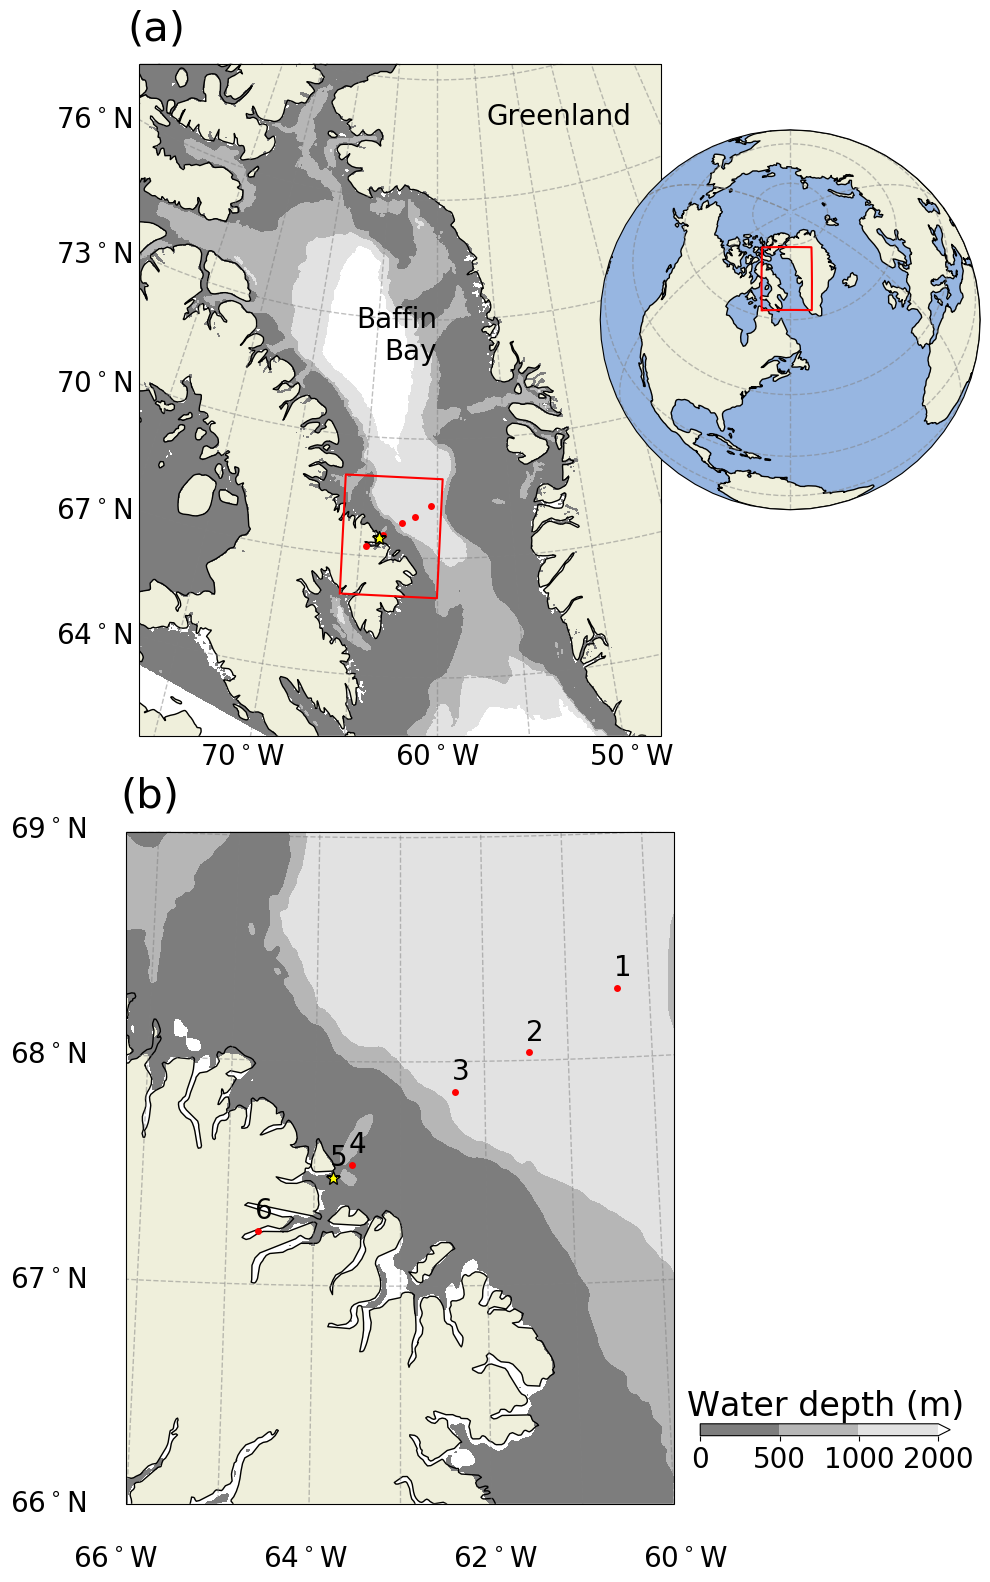

In [5]:
plotbathymetry=True  

with plt.style.context('mplstyles/maps.mplstyle'):
    fig=plt.figure(figsize=(10, 16))
    
    # --- CCGS AMUNDSEN 2018, LEG 2B
    proj_am=ccrs.LambertConformal(central_longitude=-63,
                                  central_latitude=67.5,
                                  standard_parallels=(67,68))
    ax_am=fig.add_subplot(223,projection = proj_am)
    ax_am.coastlines(resolution='10m')
    ax_am.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_am.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-66,-60,66,69]
    ax_am.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_am.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-68,-58))
    gl.ylocator = mticker.FixedLocator(np.arange(65,70))

    # stations
    for station in stations:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_am)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_am.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)
        
    # longitude labels
    y0,_ = ax_am.get_ylim()
    for lon in [-66,-64,-62,-60]:
        x0,_ = proj_am.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top')

    # latitude labels
    x0,_ = ax_am.get_xlim()
    someLons = np.arange(-80,-50)
    for lat in np.arange(66,69+1):
        # interpolate latitude circle to map boundary
        xyzArray = proj_am.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    if plotbathymetry:
        # color bar for bathymetry
        cmap = plt.cm.get_cmap('Greys')
        cmap = cmap.from_list('Custom cmap',
                              [cmap(i) for i in range(150,50,-1)], 100)
        cmap.set_over('white')
        bounds = [0,500,1000,2000]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # IBCAO bathymetry
    if plotbathymetry:
        top = loadmat('data/DataS1_observations_IBCAO_1min_bathy.mat')
        lon_ibcao,lat_ibcao=np.meshgrid(top['x'],top['y'])
        z_ibcao=-top['IBCAO_1min']
        hb_am=ax_am.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_am),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')
        axcb_am= fig.colorbar(hb_am,ax=ax_am,orientation='horizontal')
        axcb_am.ax.set_title('Water depth (m)')
        axcb_am.ax.set_position([0.70,-0.10, 0.25,0.20])
    
    # labels for stations
    for i,station in enumerate(stations):
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_am)
        ax_am.text(xstation+3e3,ystation+1e4,i+1,
                   horizontalalignment = 'center',
                   verticalalignment='center')
    # text
    b_lon,b_lat = -66.5, 69.1,
    ax_am.text(b_lon,b_lat,'(b)',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    
    # --- BAFFIN BAY
    proj_bb=ccrs.LambertConformal(central_longitude=-60,
                                  central_latitude=70,
                                  standard_parallels=(65,75))
    ax_bb=fig.add_subplot(221,projection=proj_bb)
    ax_bb.coastlines(resolution='50m')
    ax_bb.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_bb.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-76,-48,62,79]
    ax_bb.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_bb.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator([-80,-75,-70,-65,-60,
                                        -55,-50,-45,-40,-35])
    gl.ylocator = mticker.FixedLocator(np.arange(58,84,3))

    # stations
    for station in stations:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_bb)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_bb.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)

    # longitude labels
    y0,_ = ax_bb.get_ylim()
    for lon in [-70,-60,-50]:
        x0,_ = proj_bb.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top',
                fontsize=20)

    # latitude labels
    x0,_ = ax_bb.get_xlim()
    someLons = np.arange(-120,-40,1)
    for lat in np.arange(64,78,3):
        # interpolate latitude circle to map boundary
        xyzArray = proj_bb.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    # IBCAO bathymetry
    if plotbathymetry:
        hb_bb=ax_bb.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_bb),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')

    # text
    a_lon,a_lat = -98, 77.5
    ax_bb.text(a_lon,a_lat,'(a)',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    greenland_lon,greenland_lat = -38, 77
    ax_bb.text(greenland_lon,greenland_lat,'Greenland',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())
    baffinbay_lon,baffinbay_lat = -60, 72
    ax_bb.text(baffinbay_lon,baffinbay_lat,'Baffin\nBay',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())

    # rectangle
    extentStudyarea = ax_am.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_am.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_bb.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_bb.plot(xBoxTransformed,yBoxTransformed,'r')
    ax_bb.relim()
    
    # --- WORLD MAP
    proj_wm = ccrs.NearsidePerspective(central_longitude=-60,
                                       central_latitude=60)
    ax_wm = fig.add_subplot(222,projection = proj_wm)
    ax_wm.set_global()
    ax_wm.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax_wm.add_feature(cartopy.feature.OCEAN)
    gl = ax_wm.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    extentStudyarea = ax_bb.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_bb.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_wm.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_wm.plot(xBoxTransformed,yBoxTransformed,'r')
    
    ax_wm.set_position( [0.60,0.60 ,0.38,0.38])
    ax_bb.set_position( [0.10,0.53 ,0.60,0.42])
    ax_am.set_position( [0.10,0.05 ,0.60,0.42])

    # --- SAVE
    if plotbathymetry:
        plt.savefig('figures_progress/maps.png')
    else:
        plt.savefig('figures_progress/maps_nobathy.png')

# Select year

In [6]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [7]:
gridfile='data/DataS8_output_mitgcm/exp0/grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [8]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [9]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

In [10]:
RF_above151=np.array(RF[RF<151])

# Observations

## Observations: ice concentration

Break-up was on 18 July 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [11]:
obsice=np.empty(365)
obsice[:]=np.NaN
obsice[0:199]=1
obsice[199]=0

Day of *in situ* sea ice break-up:

In [12]:
obs_breakup=next(i for i,v in enumerate(obsice) if v < 0.50)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness (cm).

### Observations: snow and ice thickness: load dataset

In [13]:
def load_thickness():
    fname='data/DataS2_observations_Qikiqtarjuaq/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [14]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [15]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]

We select the observations of ice thickness at the ice camp 2016.

In [16]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: PAR

## PAR

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

### Observations: PAR: Load dataset

In [17]:
def load_par():
    fname='data/DataS2_observations_Qikiqtarjuaq/66399.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [18]:
par_df=load_par()

### Observations: PAR: Select

In [19]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [20]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [21]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

### Observations: PAR: calculate

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [22]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

### Observations: PAR: 3 m

In [23]:
array1d_iT_obsPAR3m=np.empty(365)
array1d_iT_obsPAR3m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        parwater_df[parwater_df.doy==doy]['depth'],
        parwater_df[parwater_df.doy==doy]['par'])
    array1d_iT_obsPAR3m[doy-1]=y_interp(3)

### Observations: PAR: isolume

In [24]:
array1d_iT_obsisolume=np.empty(365)
array1d_iT_obsisolume[:]=np.NaN
c_isolume=0.415 # mol photons m^-2 d^-1
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    if parwater_onedoy_df.iloc[0,:]['par'] > c_isolume:
        idx_isolume=vstats.find_idx_nearest \
        (array=parwater_onedoy_df['par'],
         value=c_isolume)
        isolume=parwater_onedoy_df['depth'].iloc[idx_isolume]
        array1d_iT_obsisolume[doy-1]=isolume

## Observations: nutrients

The file Nutrients from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ nutrients at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'no3_um_l', 'po4_um_l', and 'sioh4_um_l' are the nitrate, phosphate, and silicic acid concentrations, respectively ($\mathrm{ \mu }$M).

### Observations: nutrients: load dataset

In [25]:
def load_nutrients():
    fname='data/DataS2_observations_Qikiqtarjuaq/66412.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'bottom_depth_m': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'filter_type': 'category',
                'quality_flag': 'category',
                'dilution_factor': np.float32,
                'no3_um_l': np.float32,
                'no2_um_l': np.float32,
                'no2_and_no3': np.float32,
                'po4_um_l': np.float32,
                'sioh4_um_l': np.float32,
                'n_ice_samples_ice_camp_2016': np.float32,
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                no3_um_l='no3',
                po4_um_l='po4',
                sioh4_um_l='sioh4'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [26]:
nutrients_df=load_nutrients()

### Observations: nutrients: select

We select the observations of nitrate at the ice camp 2016 in the water column made with a GFF filter.

In [27]:
nutrients_df=nutrients_df[(nutrients_df.mission=='ice_camp_2016') \
              & (nutrients_df.sample_type=='water') \
             & (nutrients_df.filter_type=='gff')]

Find duplicates.

In [28]:
g=nutrients_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

No duplicates.

### Observations: nutrients: 3 m

In [29]:
array1d_iT_obsnitrate3m=np.empty(365)
array1d_iT_obsnitrate3m[:]=np.NaN
array1d_iT_obssilica3m=np.empty(365)
array1d_iT_obssilica3m[:]=np.NaN
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['no3'])
    array1d_iT_obsnitrate3m[doy-1]=y_interp(3)
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['sioh4'])
    array1d_iT_obssilica3m[doy-1]=y_interp(3)

## Observations: total dissolved inorganic iron

### Observations: total dissolved inorganic iron: load dataset

in $\mathrm{ \mu M=mmol\ Fe\ m^{-3} }$

In [30]:
fname='data/DataS5_observations_davis_strait.csv'
fet_df=pd.read_csv(
    fname,
    dtype={
        'doy':np.int64,
        'depth':np.float32,
        'Fe_D_CONC_BOTTLE_nmol_kg':np.float32
    }
)
fet_df['depth']=-fet_df['depth']
# fet_df

In [31]:
# nmol kg^-1 ===> mmol m^-3
fet_df['Fe_D_CONC_BOTTLE_nmol_kg']=fet_df['Fe_D_CONC_BOTTLE_nmol_kg']/1000
fet_df.rename({'Fe_D_CONC_BOTTLE_nmol_kg':'Fe_D_CONC_BOTTLE_mmol_m3'},
             axis='columns',
             inplace=True)
# fet_df

## Observations: chlorophyll *a* by HPLC

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations: chlorophyll *a* by HPLC: load dataset

In [32]:
def load_pigment():
    fname='data/DataS2_observations_Qikiqtarjuaq/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [33]:
chlHPLC_df=load_pigment()

### Observations: chlorophyll *a* by HPLC: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [34]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

remove negative chlorophyll a

In [35]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

find duplicates

In [36]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: depth, dtype: float64

inspect duplicates for doy=146

In [37]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,146
20365,5.0,0.1086,148
20366,10.0,0.0890,146


By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [38]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [39]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,148
20365,5.0,0.1086,148
20366,10.0,0.0890,148


Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [40]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy  doy
120  120    2.0
Name: doy, dtype: float64

In [41]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20299,1.5,0.0355,120
20300,5.0,0.0253,120


By human judgement, I drop these observations.

In [42]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations: chlorophyll *a* by HPLC: vertically integrated chlorophyll *a* (0-40m)

in $\mathrm{ mg\ Chl\ m^{-2} }$

In [43]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    10])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  10])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    10])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         15])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    10])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,15,     0])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,15,     0,   0])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45, 60])
weights_case8=np.array([     5.75,        9.25,10,12.5, 2.5,0])

In [44]:
nT=365
array1d_iT_obsvint40mchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvint40mchlHPLC[iT]=obsvintchlHPLC

### Observations: chlorophyll *a* by HPLC: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [45]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [46]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

# Observations from literature

In [47]:
obsphotofile='data/DataS7_literature.csv'
obsphoto_df=pd.read_csv(obsphotofile)

## Observations from literature: maximum photosynthesis rate at saturation irradiance in nutrient replete conditions ($P^C_{max} \gamma^T$, $\mathrm{ d^{-1} }$)

In [48]:
obsPCmax_df=obsphoto_df[obsphoto_df.parameter=='PCmax']

## Observations from literature: lineare initial slope of the Chl a-specific photosynthesis versus irradiance curve ($\alpha^{chl}$, $\mathrm{ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1} }$)

In [49]:
obsalphachl_df=obsphoto_df[obsphoto_df.parameter=='alphastar']

## Observations from literature: light saturation parameter ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [50]:
obsEk_df=obsphoto_df[obsphoto_df.parameter=='Ek']

# Outputs from model NEMO-LIM3

## Output from model NEMO-LIM3 and input into package gud of MITgcm: sea ice concentration

The file siarea.nemo.2016.365.32bits.bin contains data from a simulation of NEMO3.6 LIM3.6 configured by Gaetan Olivier (UBO) for the Qikiqtarjuaq sea ice camp location ($67.48^\circ N$, $-63.79^\circ E$) in 2016. It contains sea ice concentration (unitless).

In [51]:
ice=np.fromfile('data/DataS4_output_nemo_lim3/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

Day of simulated sea ice freeze-up:

In [52]:
sim_freezeup=next(i for i,v in reversed(list(enumerate(ice))) if v < 0.50)

## Output from model NEMO-LIM3 : snow volume

The file Ice_d.nc is from a simulation of NEMO3.6 LIM3.6 configured by Gaetan Olivier (UBO) for the Qikiqtarjuaq sea ice camp location ($67.48^\circ N$, $-63.79^\circ E$) from 2013 to 2017. The variable snow_volume contains the snow volume (m). The variable ice_volume contains the ice volume (m). The variables are at indices (1,1) meaning centre of grid point was used.

Snow volume is the weighted average of snow thickness averaged by the sea ice concentration. For example, if there is 50% of sea ice concentration and 2 m of snow on the sea ice-covered part of the pixel, snow volume will be 1 m. The expression 'snow thickness' in the labels of the plots corresponds to the variable 'snow volume' in NEMO-LIM3 and the NetCDF file Ice_d.nc.

In [53]:
ice_file='data/DataS4_output_nemo_lim3/Ice_d.nc'

From 2013 to 2017.

In [54]:
array1d_iT_snow_volumefull=\
netcdf_tools.read_netcdf(ice_file,'snow volume')
array1d_iT_snow_volumefull=array1d_iT_snow_volumefull[:,1,1]

From 2016.

In [55]:
array1d_iT_snow_volume=array1d_iT_snow_volumefull[365*3:365*4]

## Output from model NEMO-LIM3 : ice volume

Ice volume is the weighted average of ice thickness averaged by the sea ice concentration. For example, if there is 50% of sea ice concentration and 2 m of ice on the sea ice-covered part of the pixel, ice volume will be 1 m. The expression 'ice thickness' in the labels of the plots corresponds to the variable 'ice volume' in NEMO-LIM3 and the NetCDF file Ice_d.nc.

From 2013 to 2017.

In [56]:
array1d_iT_ice_volumefull=\
netcdf_tools.read_netcdf(ice_file,'ice volume')
array1d_iT_ice_volumefull=array1d_iT_ice_volumefull[:,1,1]

From 2016.

In [57]:
array1d_iT_ice_volume=array1d_iT_ice_volumefull[365*3:365*4]

# Model

## Model: traits

### Model: traits: set indir

In [58]:
indir='data/DataS8_output_mitgcm/exp0'

### Model: traits: create RunInfo object

In [59]:
info=gudinfo.RunInfo(indir)

### Model: traits: Equivalent spherical diameters (ESD, $\mathrm{ \mu m }$)

In [60]:
esd=info.f['esd'].to_numpy()

### Model: traits: Maximum growth rate ($P^C_{max}$, $\mathrm{ d^{-1} }$)

In [61]:
stod=86400 # seconds to day
pcmax=info.f['pcmax'].to_numpy() # s^-1
pcmax=pcmax*stod                 # d^-1

### Half saturation for growth on nitrate ($k_{NO_3}$, $\mathrm{ mmol\ N\ m^{-3} }$)

In [62]:
ksatno3=info.f['ksatno3'].to_numpy()

### Maximum grazing rate ($g_{max}$, $\mathrm{ d^{-1} }$)

In [63]:
stod=86400 # seconds to day
gmax=info.f['grazemax'].to_numpy() # s^-1
gmax=gmax*stod                     # d^-1

## Model: outputs

The file car.0000000000.t001.nc was the output of the default (EXP-0) simulation.

The file car.0000000000.t001.nc (180 MB) was too large for GitHub. It is available on my [Google Drive](https://drive.google.com/drive/folders/1zOh8qWl0kKqXkfUTQYvIUzrFzJ_7v3II?usp=sharing).

In [64]:
carfile='data/DataS8_output_mitgcm/exp0/car.0000000000.t001.nc'

## Model: PAR

### Model: mean PAR: 3 m

($\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$)

In [65]:
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARfullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PAR').squeeze().transpose()
if np.all(array2d_idepth_iT_PARfullumolEonm2s==0):
    #define GUD_PARUICE
    array2d_idepth_iT_PAR_icefullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
    array2d_idepth_iT_PAR_icefull=array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
    array2d_idepth_iT_PAR_owfullumolEonm2s=netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
    array2d_idepth_iT_PAR_owfull=array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
    (ndepths,ndays)=array2d_idepth_iT_PAR_icefull.shape
    array2d_idepth_iT_icefull=np.tile(ice,(ndepths,ndays//365))
    array2d_idepth_iT_meanPARfull=array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
    +array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
else:
    #undef GUD_PARUICE
    array2d_idepth_iT_meanPARfull=array2d_idepth_iT_PARfullumolEonm2s*1e-6*stod
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modPAR3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_meanPAR[3,iT],array2d_idepth_iT_meanPAR[2,iT]]
    PAR3m=np.interp(x,xp,fp)
    array1d_iT_modPAR3m[iT]=PAR3m

($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [66]:
array2d_idepth_iT_meanPARumolEonm2s=array2d_idepth_iT_meanPAR/1e-6/stod

### Model: mean PAR: isolume $\mathrm{ z_{0.415}=0.415\ mol\ photons\ m^{-2} d^{-1} }$

In [67]:
c_isolume=0.415 # mol photons m^-2 d^-1
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modisolume=np.empty(ndays)
array1d_iT_modisolume[:]=np.NaN
for iT in first_year:
    array1d_idepth_meanPAR=array2d_idepth_iT_meanPAR[:,iT]
    if array1d_idepth_meanPAR[0]>c_isolume:
        idx_isolume=vstats.find_idx_nearest(array=array1d_idepth_meanPAR,
                                           value=c_isolume)
        isolume=RC[idx_isolume]
        array1d_iT_modisolume[iT]=isolume

## Model: nutrients

In [68]:
array2d_idepth_iT_modno3full=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
array2d_idepth_iT_modno3=array2d_idepth_iT_modno3full[:,array1d_iT1y_iT]
array2d_idepth_iT_modsioh4full=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
array2d_idepth_iT_modsioh4=array2d_idepth_iT_modsioh4full[:,array1d_iT1y_iT]
array2d_idepth_iT_modpo4full=netcdf_tools.read_netcdf(carfile, 'TRAC05').squeeze().transpose()
array2d_idepth_iT_modpo4=array2d_idepth_iT_modpo4full[:,array1d_iT1y_iT]

### Model: nutrients: 3 m

in $\mathrm{ \mu M }$

In [69]:
(ndepths,ndays)=array2d_idepth_iT_modno3.shape
array1d_iT_modnitrate3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modno3[3,iT],array2d_idepth_iT_modno3[2,iT]]
    nitrate3m=np.interp(x,xp,fp)
    array1d_iT_modnitrate3m[iT]=nitrate3m
(ndepths,ndays)=array2d_idepth_iT_modsioh4.shape
array1d_iT_silicicacid3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modsioh4[3,iT],array2d_idepth_iT_modsioh4[2,iT]]
    silica3m=np.interp(x,xp,fp)
    array1d_iT_silicicacid3m[iT]=silica3m

## Model: total dissolved inorganic iron

in $\mathrm{ \mu M }$

In [70]:
array2d_idepth_iT_modfetfull=netcdf_tools.read_netcdf(carfile, 'TRAC07').squeeze().transpose()
array2d_idepth_iT_modfet=array2d_idepth_iT_modfetfull[:,array1d_iT1y_iT]

## Model: chlorophyll *a*

In [71]:
indir_exp0='data/DataS8_output_mitgcm/exp0'

In [72]:
chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
array2d_idepth_iT_modchlfull=\
read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

In [73]:
# get vertically integrated Chl a for one year}
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT,depth_end):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

### Model: chlorophyll *a*: vertically integrated chlorophyll *a* (0-40m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [74]:
depth_end=40
array1d_iT_modvint40mchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

### Model: chlorophyll *a*: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [75]:
depth_end=100
array1d_iT_modvintchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

## Model: chlorophyll $a$ in simulation EXP-1

### Model: chlorophyll *a* in simulation EXP-1: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [76]:
indir_exp1='data/DataS8_output_mitgcm/exp1'
depth_end=100
array1d_iT_exp1vintchl\
=get_array1d_iT_vintchl(indir_exp1,array1d_iT1y_iT,depth_end)

## Model: chlorophyll $a$ in simulation EXP-2

### Model: chlorophyll *a* in simulation EXP-2: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [77]:
indir_exp2='data/DataS8_output_mitgcm/exp2'
depth_end=100
array1d_iT_exp2vintchl\
=get_array1d_iT_vintchl(indir_exp2,array1d_iT1y_iT,depth_end)

## Model: chlorophyll $a$ in simulation EXP-3

### Model: chlorophyll *a* in simulation EXP-3: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [78]:
indir_exp3times0_25='data/DataS8_output_mitgcm/exp3times0_25'
indir_exp3times0_50='data/DataS8_output_mitgcm/exp3times0_50'
indir_exp3times2_00='data/DataS8_output_mitgcm/exp3times2_00'
indir_exp3times4_00='data/DataS8_output_mitgcm/exp3times4_00'
depth_end=100
array1d_iT_exp3times0_25vintchl\
=get_array1d_iT_vintchl(indir_exp3times0_25,array1d_iT1y_iT,depth_end)
array1d_iT_exp3times0_50vintchl\
=get_array1d_iT_vintchl(indir_exp3times0_50,array1d_iT1y_iT,depth_end)
array1d_iT_exp3times2_00vintchl\
=get_array1d_iT_vintchl(indir_exp3times2_00,array1d_iT1y_iT,depth_end)
array1d_iT_exp3times4_00vintchl\
=get_array1d_iT_vintchl(indir_exp3times4_00,array1d_iT1y_iT,depth_end)

## Model: temperature

In [79]:
tavefile='data/DataS8_output_mitgcm/exp0/tave.0000000000.t001.nc'
array2d_idepth_iT_Ttavefull=netcdf_tools.read_netcdf(tavefile,'Ttave').squeeze().transpose()
array2d_idepth_iT_Ttavefull[-1,:]=np.nan
array2d_idepth_iT_Ttave=array2d_idepth_iT_Ttavefull[:,array1d_iT1y_iT]
minT=np.nanmin(array2d_idepth_iT_Ttave)
maxT=np.nanmax(array2d_idepth_iT_Ttave)

In [80]:
IPython.display.Markdown(
'''The interval of temperature ($^{\circ} C$) is
$[%f,%f].$'''
    %(minT,maxT)
)

The interval of temperature ($^{\circ} C$) is
$[-1.755564,2.919083].$

## Model: $\gamma^T$

The modification of growth rate by temperature (unitless, between 0 and 1) is

$\gamma^T=\tau_T e^{A_T(\frac{1}{T+273.15}-\frac{1}{T_N})}$

where

$\tau_T$ is the normalization factor for temperature function $=0.8$ (unitless)

$A_T$ is a coefficient $=-4000$ K

$T$ is the ambient temperature (K)

$T_N$ is the reference temperature
$=20\mathrm{ ^{\circ}C }+273.15\mathrm{ ^{\circ}C }=293.15$ K

In [81]:
tau_T=0.8 # unitless
A_T=-4000 # K
T_N=20+273.15 # K
mingammaT=tau_T*math.exp(A_T*(1/(minT+273.15)-1/T_N))
maxgammaT=tau_T*math.exp(A_T*(1/(maxT+273.15)-1/T_N))

In [82]:
IPython.display.Markdown(
'''The interval of $\gamma^T$ (unitless)
in the simulation is
$[%f,%f].$'''
    %(mingammaT,maxgammaT)
)

The interval of $\gamma^T$ (unitless)
in the simulation is
$[0.267952,0.343909].$

## Model: maximum photosynthesis rate at saturation irradiance in nutrient replete conditions ($P^C_{max} \gamma^T$, $\mathrm{ d^{-1} }$)

In [83]:
minpcmaxgammaT=pcmax[15-1]*mingammaT
maxpcmaxgammaT=pcmax[15-1]*maxgammaT

In [84]:
IPython.display.Markdown(
'''The interval of $P^C_{max}\ \gamma^T(T)$ for the diatom 6.6 $\mu$m in $d^{-1}$ is
$[%f,%f].$'''
    %(minpcmaxgammaT,maxpcmaxgammaT)
)

The interval of $P^C_{max}\ \gamma^T(T)$ for the diatom 6.6 $\mu$m in $d^{-1}$ is
$[0.489756,0.628588].$

## Model: lineare initial slope of the Chl a-specific photosynthesis versus irradiance curve ($\alpha^{chl}$, $\mathrm{ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1} }$)

In [85]:
alphachl=info.f['alphachl'] # mmol C (mg Chl a)^-1 (umol photons m^-2)^-1
alphachl=alphachl[15-1]

For your information, $\alpha^{chl}$ is the same for all numerical phytoplankton types.

We convert the units to compare with literature.

In [86]:
modalphachl_modunits=alphachl # mmol C (mg Chl a)^-1 (umol photons m^-2)^-1
mmolC2molC=1E-3               # mol C (mmol C )^-1
molarmassC=12.011             # g C (mol C)^-1
mgChla2gChla=1E3              # mg Chl a (g Chl a)^-1
s2h=3600                      # sh^-1
modalphachl=modalphachl_modunits*mmolC2molC*molarmassC*mgChla2gChla*s2h

In [87]:
IPython.display.Markdown(
r'''$\alpha^{chl} = %.3G
\ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}$.'''
    %(modalphachl)
)

$\alpha^{chl} = 0.0346
\ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}$.

## Model: light saturation parameter when there is light or no light ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

Maximum photosynthesis rate at saturation irradiance
in nutrient replete conditions for numerical diatom 6.6 $\mu$m
in $\mathrm{ d^{-1} }$

$P^C_m(j=15) = P^C_{max}(j=15) * \gamma^T(T)$

In [88]:
array2d_idepth_iT_modPCmrep15=pcmax[15-1] \
* tau_T*np.exp(A_T*(1/(array2d_idepth_iT_Ttave+273.15)-1/T_N))

Chlorophyll $a$ for numerical diatom 6.6 $\mu$m
($\mathrm{ mg\ Chl\ a\ m^{-3} }$)

In [89]:
chlfile='data/DataS8_output_mitgcm/exp0/chl.0000000000.t001.nc'
array2d_idepth_iT_diatom7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC84').squeeze().transpose()
array2d_idepth_iT_diatom7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom7umchl\
=array2d_idepth_iT_diatom7umchlfull[:,array1d_iT1y_iT]

Biomass for numerical diatom 6.6 $\mu$m ($\mathrm{ mmol\ C\ m^{-3} }$)

In [90]:
array2d_idepth_iT_diatom7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC35').squeeze().transpose()
array2d_idepth_iT_diatom7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom7umbio\
=array2d_idepth_iT_diatom7umbiofull[:,array1d_iT1y_iT]

Chl $a$: C ratio for numerical diatom 6.6 $\mu$m
($\mathrm{ mg\ Chl\ {a}\ (mmol\ C)^{-1} }$)

In [91]:
array2d_idepth_iT_modtheta15\
=array2d_idepth_iT_diatom7umchl/array2d_idepth_iT_diatom7umbio

Light saturation parameter for numerical diatom 6.6 $\mu$m
($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

$E_k= \frac{P^C_m}{\alpha^{chl} \cdot \theta \cdot \frac{86400\ s}{d}}$

where

$E_k$: light saturation parameter
($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$).

$P^C_m$: carbon-specific maximum photosynthesis rate
($\mathrm{ d^{-1} }$).

$\alpha^{chl}$: linear initial slope of the Chl *a*-specific photosynthesis versus irradiance curve
($\mathrm{ mmol\ C\ (mg\ Chl\ a)^{-1}\ (\mu mol\ photons\ m^{-2})^{-1} }$).

$\theta$: Chl a : C ratio
($\mathrm{ mg\ Chl\ a\ (mmol\ C)^{-1} }$).

In [92]:
s2d=86400 # s d^-1
array2d_idepth_iT_modEk15=\
array2d_idepth_iT_modPCmrep15 \
/ (modalphachl_modunits * array2d_idepth_iT_modtheta15 * s2d)

## Model: light saturation parameter when there is light  ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [93]:
array2d_idepth_iT_modEk15light=array2d_idepth_iT_modEk15.copy()
array2d_idepth_iT_modEk15light[array2d_idepth_iT_meanPARumolEonm2s<5]=np.nan

# Plot

## Plot: sea ice, PAR, nutrients, Chl *a*, and $z_{0.415}$

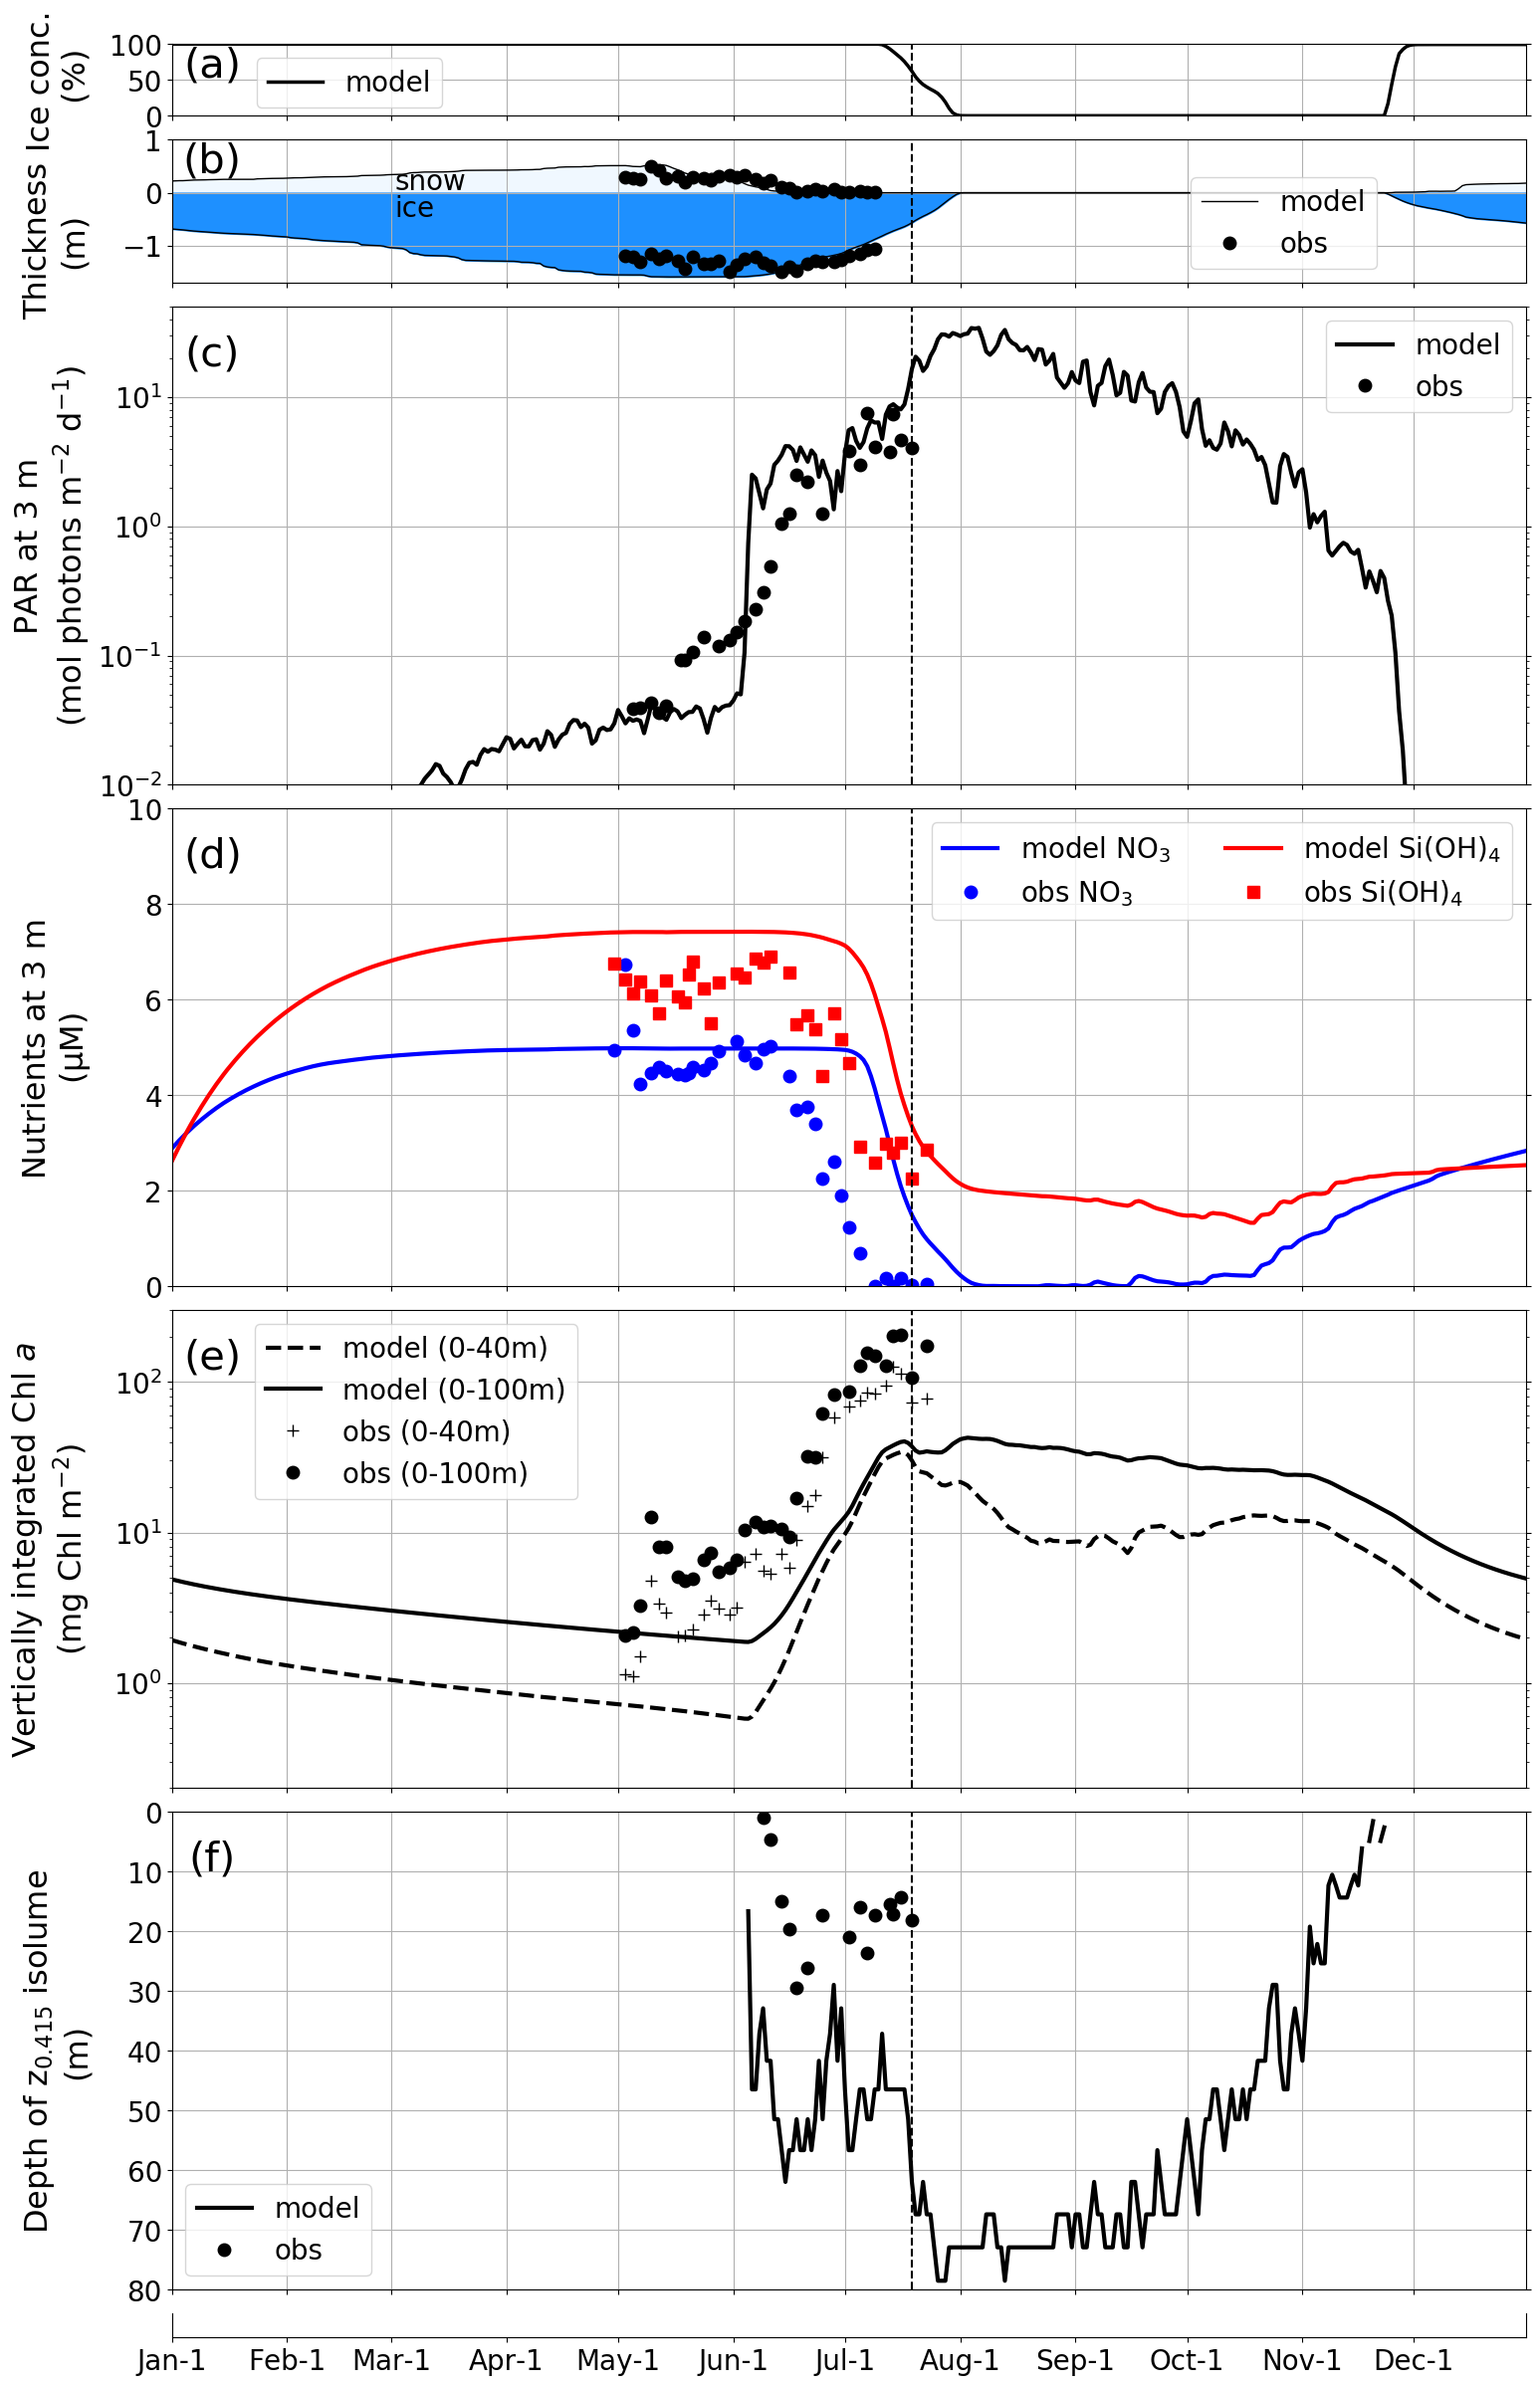

In [94]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- ICE CONCENTRATIONS
    ax=axs[0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)',bbox=box)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(bbox_to_anchor=(0.21,1.00))
    plt.text(0.03,0.7,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- SNOW AND ICE THICKNESS
    ax=axs[1]
    h1=ax.fill_between(first_year,array1d_iT_snow_volume,
                       linestyle='-',color='aliceblue',linewidth=1)
    h2=ax.plot(first_year,array1d_iT_snow_volume,
               linestyle='-',color='black',lw=1)
    h3=ax.plot((snow_thickness_df['doy']-1).to_numpy(),
              snow_thickness_df['sample_thickness_m_average'].to_numpy(),
              'o',color='black')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    mpl.axis.Axis.set_label_coords(ax.yaxis,-0.061,0.3)
    ax.set_ylim(-1.7,1.0)
    ax.grid()
    ax.text(60,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    h4=ax.fill_between(first_year,-array1d_iT_ice_volume,
                       linestyle='-',color='dodgerblue',linewidth=1)
    h5=ax.plot(first_year,-array1d_iT_ice_volume,
               linestyle='-',color='black',lw=1)
    h6=ax.plot((ice_thickness_df['doy']-1).to_numpy(),
              -ice_thickness_df['sample_thickness_m_average'].to_numpy(),
              'o',color='black')
    ax.text(60,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend([h2[0],h3[0]],['model','obs'],loc=4,
              bbox_to_anchor=(0.90,0.00))
    plt.text(0.03,0.85,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,linestyle='--',color='black')

    # --- sfc PAR
    ax=axs[2]
    h1=ax.plot(first_year,array1d_iT_modPAR3m,'-',color='black',lw=3)
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('PAR at 3 m\n(mol photons m$^{-2}$ d$^{-1})$',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E-2,50)
    ax.grid()
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    h2=ax.plot(first_year,array1d_iT_obsPAR3m,
               'o',color='black')
    ax.legend([h1[0],h2[0]],['model','obs'],loc=0, ncol=1)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- sfc NO3 + sfc SiO2
    ax=axs[3]
    h1=ax.plot(first_year,array1d_iT_modnitrate3m,'-',color='blue',lw=3)
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Nutrients at 3 m\n($\mathrm{ \mu M }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,10)
    ax.grid()
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    h2=ax.plot(first_year,array1d_iT_silicicacid3m ,'-',color='red', lw=3)
    h3=ax.plot(first_year,array1d_iT_obsnitrate3m,
               'o',color='blue')
    h4=ax.plot(first_year,array1d_iT_obssilica3m ,
               's',color='red')
    ax.legend([h1[0],h3[0],
               h2[0],h4[0]],
              ['model $\mathrm{ NO_3 }$','obs $\mathrm{ NO_3 }$',
               'model $\mathrm{ Si{(OH)}_4 }$','obs $\mathrm{ Si{(OH)}_4 }$'],
              loc=1, ncol=2)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- CHLOROPHYLL VINT
    ax=axs[4]
    h1=ax.plot(first_year,array1d_iT_modvint40mchl,
               '--',lw=3,color='black',label='model (0-40m)')
    h2=ax.plot(first_year,array1d_iT_modvintchl,
               '-',color='black',lw=3,label='model (0-100m)')
    h3=ax.plot(first_year,array1d_iT_obsvint40mchlHPLC,
               '+',color='black',label='obs (0-40m)')
    h4=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs (0-100m)')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)',
                  bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0.2,300)
    ax.grid()
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.legend(bbox_to_anchor=(0.31,1.00))
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')
    
    # -- ISOLUME
    ax=axs[5]
    h1=ax.plot(first_year,
               array1d_iT_modisolume,
               '-',
               lw=3,
               color='black',
               label='model')
    h2=ax.plot(first_year,
               array1d_iT_obsisolume,
               'o',
               color='black',
               label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Depth of $\mathrm{ z_{0.415}\ isolume }$\n(m)',
                  bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,80)
    ax.invert_yaxis()
    ax.legend(loc=3)
    ax.grid()
    plt.text(0.03,0.90,'(f)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[6]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.95  ,0.85,0.03])
    axs[1].set_position( [0.13,0.88  ,0.85,0.06])
    axs[2].set_position( [0.13,0.67  ,0.85,0.20])
    axs[3].set_position( [0.13,0.46  ,0.85,0.20])
    axs[4].set_position( [0.13,0.25  ,0.85,0.20])
    axs[5].set_position( [0.13,0.04  ,0.85,0.20])
    axs[6].set_position( [0.13,0.02  ,0.85,0.01])

with plt.style.context('mplstyles/obs_and_model.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(7,1,sharex=False,figsize=(16, 24))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_progress/qik.png',dpi=1000)

## Plot: traits

In [95]:
type_id=np.arange(1,52)

pos_Prochlorococcus=np.arange( 0, 1)
pos_Synechococcus  =np.arange( 1, 2)
pos_smalleuk       =np.arange( 2, 4)
pos_cocco          =np.arange( 4, 9)
pos_diazo          =np.arange( 9,13)
pos_Trichodesmium  =np.arange(13,14)
pos_diatoms        =np.arange(14,23)
pos_mixodino       =np.arange(23,33)
pos_zoo            =np.arange(33,49)

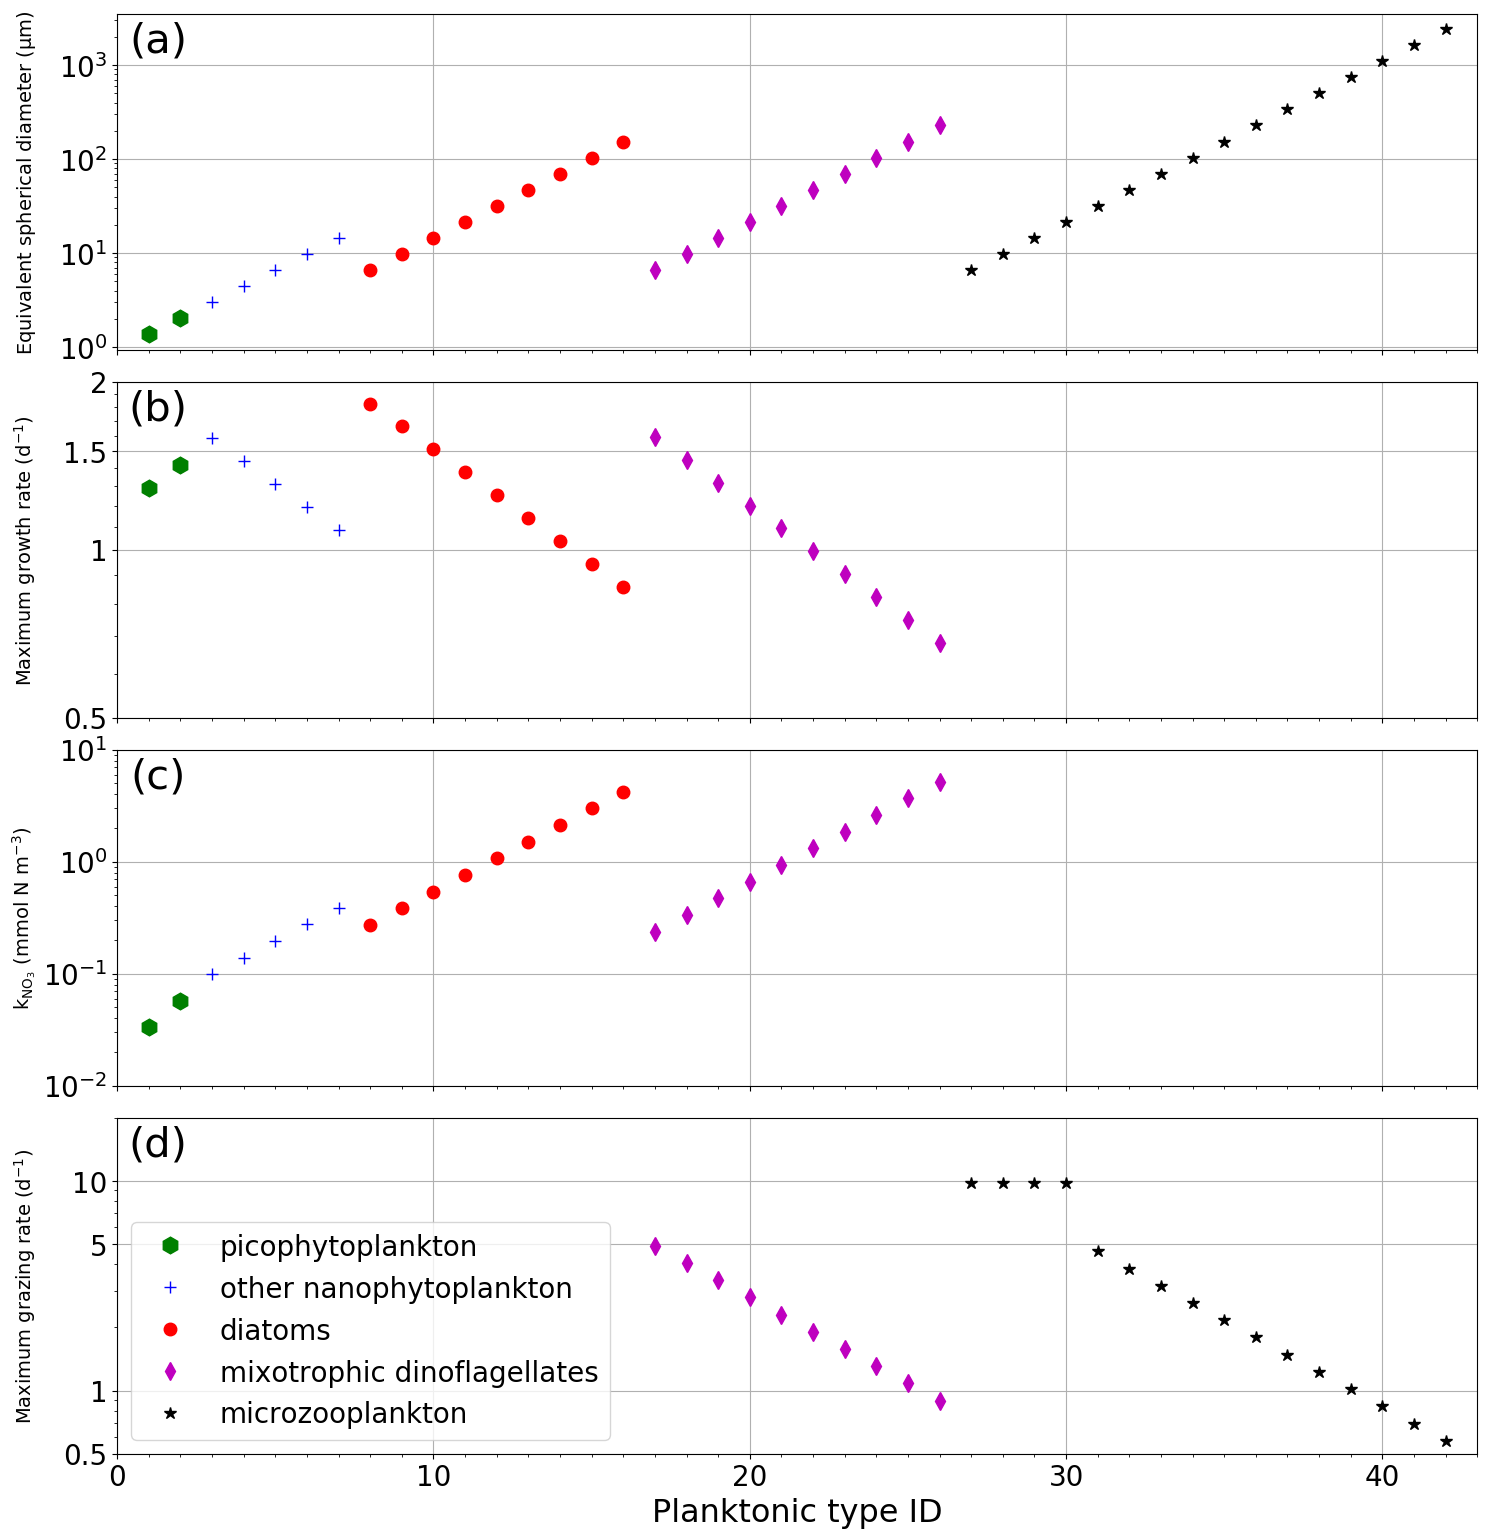

In [96]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    
    # --- EQUIVALENT SPHERICAL DIAMETER (ESD)
    ax=axs[0]
    h3=ax.plot(type_id[pos_smalleuk]-2,  esd[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     esd[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, esd[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,esd[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     esd[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Equivalent spherical diameter ($\mathrm{ \mu m }$)')
    ax.set_yscale('log')
    ax.grid()
    plt.text(0.03,0.92,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- MAXIMUM GROWTH RATE (P^C_MAX)
    ax=axs[1]
    h3=ax.plot(type_id[pos_smalleuk]-2,  pcmax[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     pcmax[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, pcmax[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,pcmax[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     pcmax[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Maximum growth rate ($\mathrm{ d^{-1} }$)')
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.FixedLocator([0.5,1,1.5,2]))
    ax.yaxis.set_minor_locator(plt.FixedLocator([0.6,0.7,0.8,0.9,
                                                 1.1,1.2,1.3,1.4,1.6,1.7,1.8,1.9]))
    ax.yaxis.set_major_formatter(plt.FixedFormatter([0.5,1,1.5,2]))
    ax.yaxis.set_minor_formatter(plt.FixedFormatter(['']))
    ax.set_ylim([0.5,2])
    ax.grid()
    plt.text(0.03,0.92,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- HALF SATURATION FOR GROWTH ON NITRATE (k_NO_3)
    ax=axs[2]
    h3=ax.plot(type_id[pos_smalleuk]-2,  ksatno3[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     ksatno3[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, ksatno3[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,ksatno3[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     ksatno3[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$\mathrm{ k_{NO_3} }$ ($\mathrm{ mmol\ N\ m^{-3} }$)')
    ax.set_yscale('log')
    ax.set_ylim([0.01,10])
    ax.grid()
    plt.text(0.03,0.92,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- MAXIMUM GRAZING RATE (G_MAX)
    ax=axs[3]
    h3=ax.plot(type_id[pos_smalleuk]-2,  gmax[pos_smalleuk],'gh',markersize=12,
               label='picophytoplankton')
    h4=ax.plot(type_id[pos_cocco]-2,     gmax[pos_cocco],   'b+',
               label='other nanophytoplankton')
    h7=ax.plot(type_id[pos_diatoms]-2-5, gmax[pos_diatoms], 'ro',
               label='diatoms')
    h8=ax.plot(type_id[pos_mixodino]-2-5,gmax[pos_mixodino],'md',
               label='mixotrophic dinoflagellates')
    h9=ax.plot(type_id[pos_zoo]-2-5,     gmax[pos_zoo],     'k*',
               label='microzooplankton')
    ax.set_xlabel('Planktonic type ID',fontsize=23)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Maximum grazing rate ($\mathrm{ d^{-1} }$)')
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.FixedLocator([0.5,1,5,10]))
    ax.yaxis.set_minor_locator(plt.FixedLocator([0.6,0.7,0.8,0.9,2,3,4,6,7,8,9,20]))
    ax.yaxis.set_major_formatter(plt.FixedFormatter([0.5,1,5,10]))
    ax.set_ylim([0.5,20])
    ax.grid()
    ax.legend(loc=3)
    plt.text(0.03,0.92,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- POSITION
    axs[0].set_position( [0.10,0.76  ,0.85,0.21])
    axs[1].set_position( [0.10,0.53  ,0.85,0.21])
    axs[2].set_position( [0.10,0.30  ,0.85,0.21])
    axs[3].set_position( [0.10,0.07  ,0.85,0.21])

with plt.style.context('mplstyles/gud_traits.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_progress/traits.png',dpi=1000)

## Plot: nitrate, silicic acid, phosphate, iron, and chlorophyll $a$

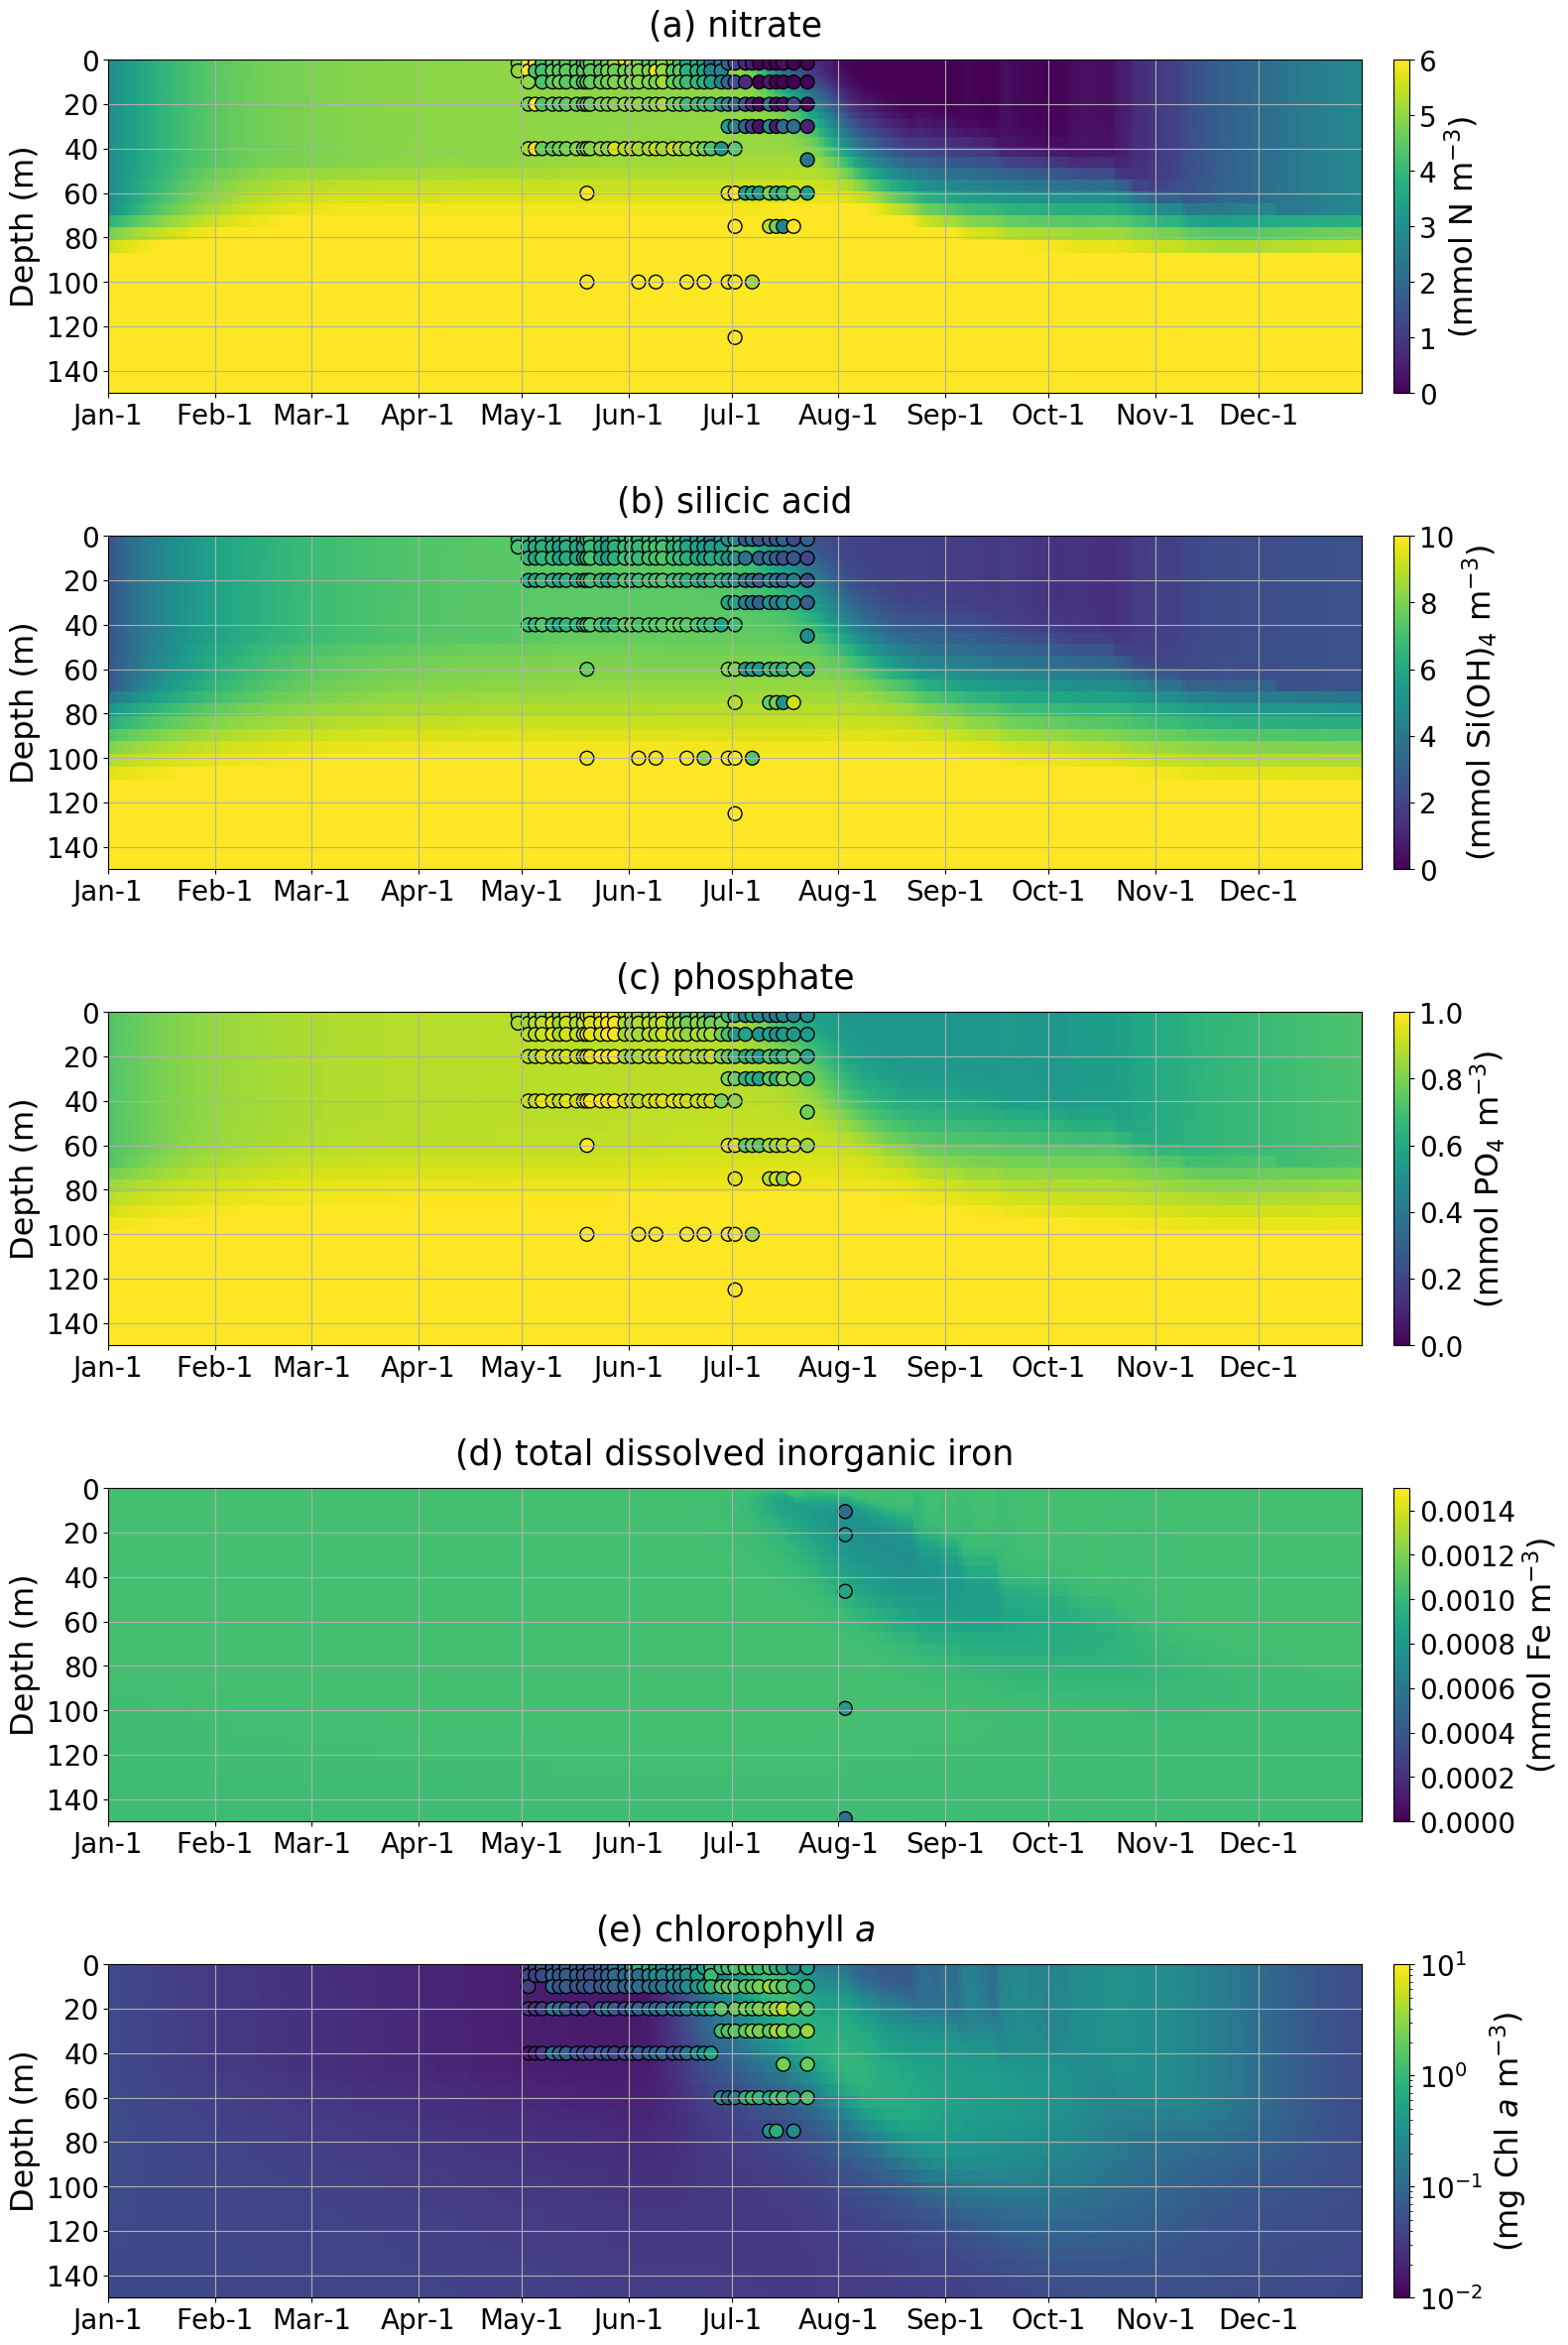

In [97]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- NITRATE
    ax=axs[0]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modno3[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=6)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['no3'],
               cmap='viridis',
               vmin=0,
               vmax=6,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.88, 0.83, 0.01, 0.14])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol N $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(a) nitrate',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- SILICIC ACID
    ax=axs[1]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modsioh4[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=10)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['sioh4'],
               cmap='viridis',
               vmin=0,
               vmax=10,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.88, 0.63, 0.01, 0.14])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol Si$\mathrm{ {(OH)}_4 }$ $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(b) silicic acid',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- PHOSPHATE
    ax=axs[2]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modpo4[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=1)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['po4'],
               cmap='viridis',
               vmin=0,
               vmax=1,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.88, 0.43, 0.01, 0.14])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol $\mathrm{ PO_4 }$ $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(c) phosphate',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- IRON
    ax=axs[3]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modfet[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=1.5E-3)
    ax.scatter(fet_df['doy']-1,
               fet_df['depth'],
               c=fet_df['Fe_D_CONC_BOTTLE_mmol_m3'],
               cmap='viridis',
               vmin=0,
               vmax=1.5E-3,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.88, 0.23, 0.01, 0.14])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol Fe $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(d) total dissolved inorganic iron',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- CHLOROPHYLL A
    ax=axs[4]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modchl[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=1E-2, vmax=10))
    ax.scatter(chlHPLC_df['doy']-1,
               chlHPLC_df['depth'],
               c=chlHPLC_df['chlHPLC'],
               cmap='viridis',
               norm=mpl.colors.LogNorm(vmin=1E-2, vmax=10),
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.88, 0.03, 0.01, 0.14])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mg Chl $a$ $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(e) chlorophyll $a$',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)

    # --- POSITION
    axs[0].set_position( [0.07,0.83  ,0.79,0.14])
    axs[1].set_position( [0.07,0.63  ,0.79,0.14])
    axs[2].set_position( [0.07,0.43  ,0.79,0.14])
    axs[3].set_position( [0.07,0.23  ,0.79,0.14])
    axs[4].set_position( [0.07,0.03  ,0.79,0.14])

with plt.style.context('mplstyles/heatmaps.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(5,1,sharex=False,figsize=(16, 24))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/conc.png',dpi=1000)

##  Plot: compare traits from literature data and simulation

In [98]:
obsPCmax_df=obsPCmax_df.copy() # to avoid a SettingWithCopyWarning
obsPCmax_df.sort_values(by=['species'],inplace=True)
obsalphachl_df=obsalphachl_df.copy() # to avoid a SettingWithCopyWarning
obsalphachl_df.sort_values(by=['species'],inplace=True)
obsEk_df=obsEk_df.copy() # to avoid a SettingWithCopyWarning
obsEk_df.sort_values(by=['species'],inplace=True)
array1d_i_modEk15light=array2d_idepth_iT_modEk15light.flatten()
pos=~np.isnan(array1d_i_modEk15light)
array1d_i_modEk15light=array1d_i_modEk15light[pos]

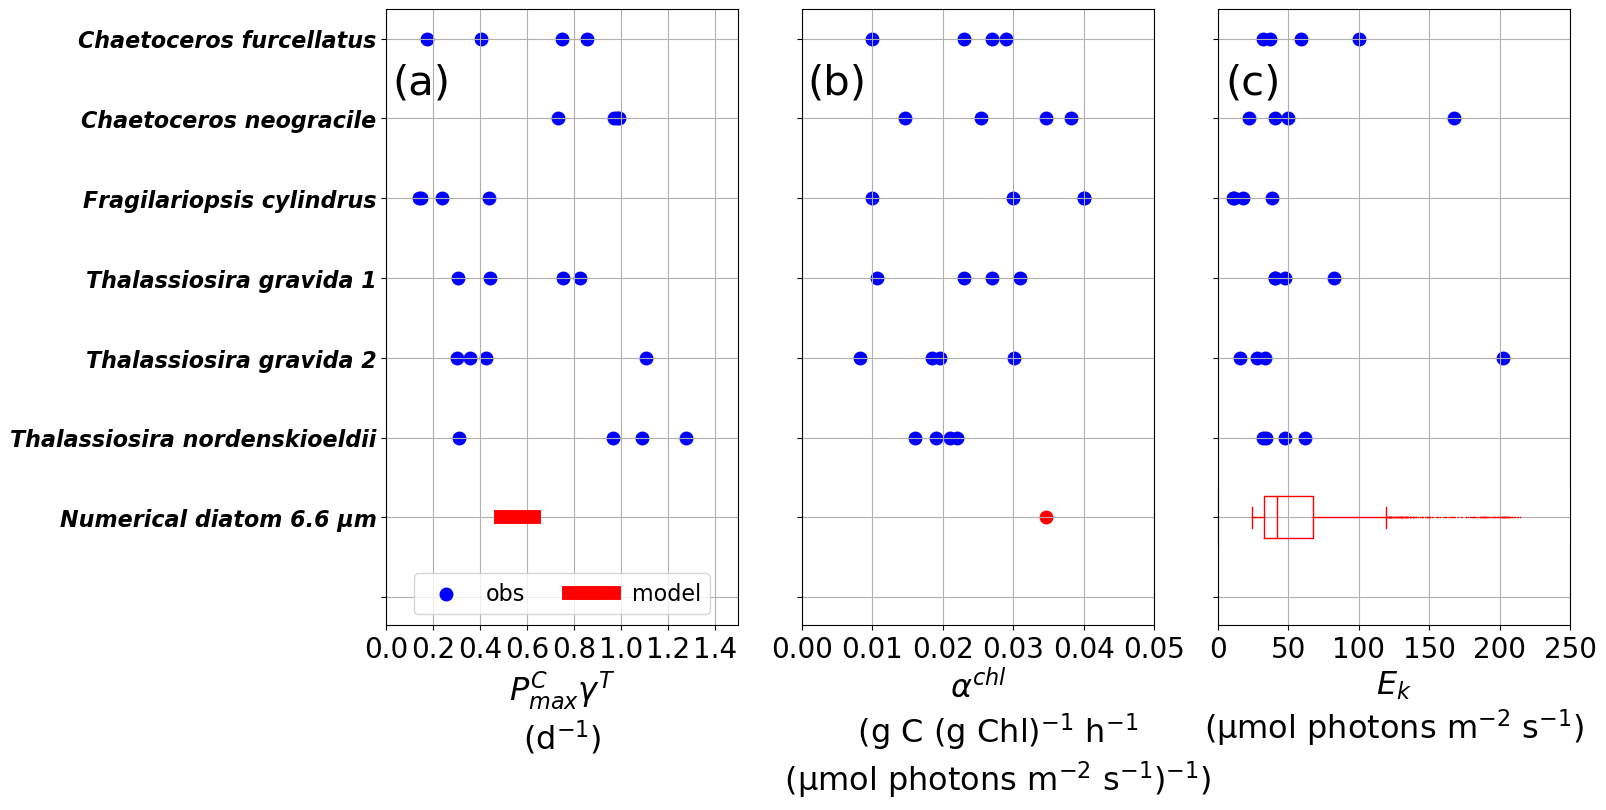

In [99]:
def make_plots(axs):
    
    # --- MAXIMUM PHOTOSYNTHESIS RATE AT SATURATION IRRADIANCE
    # --- IN NUTRIENT REPLETE CONDITIONS
    # --- (P^C_max * gamma^T)
    ax=axs[0,0]
    xlim=(0,1.5)
    h1=ax.scatter(obsPCmax_df.value,obsPCmax_df.species,
                  color='b',label='obs')
    h2=ax.axhline('',
            xmin=minpcmaxgammaT/xlim[1],
            xmax=maxpcmaxgammaT/xlim[1],
            color='red',lw=10)
    h3=ax.axhline('foo',
                 lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    # in italics
    # FULL GENUS
    ax.set_yticklabels(['Chaetoceros furcellatus',
                        'Chaetoceros neogracile',
                        'Fragilariopsis cylindrus',
                        'Thalassiosira gravida 1',
                        'Thalassiosira gravida 2',
                        'Thalassiosira nordenskioeldii',
                        'Numerical diatom 6.6 μm'
                       ],
                       fontstyle='italic',
                       fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_xlabel('$P^C_{max} \gamma^T$\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    plt.text(0.10,0.88,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.legend([h1,h2],['obs','model'],ncol=2,loc='lower center')
    
    # --- NOTHING
    axs[1,0].axis('off')
    
    # --- LINEAR INITIAL SLOPE OF THE CHL A-SPECIFIC PHOTOSYNTHESIS
    # --- VERSUS IRRADIANCE CURVE
    # --- (ALPHA^CHL)
    ax=axs[0,1]
    xlim=(0,0.05)
    h1=ax.scatter(obsalphachl_df.value,
                  obsalphachl_df.species,
                  c='b',label='obs')
    h2=ax.scatter(modalphachl,
                  '',
                  color='red')
    h3=ax.axhline('foo',
                  lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlim(xlim)
    ax.set_xlabel('''$\\alpha^{chl}$\n\
    $\mathrm{ (g\ C\ (g\ Chl)^{-1}\ h^{-1} }$\n\
    $\mathrm{ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}) }$''')
    ax.grid()
    plt.text(0.10,0.88,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- NOTHING
    axs[1,1].axis('off')
    
    # --- LIGHT SATURATION PARAMETER
    # --- (E_k)
    ax=axs[0,2]
    xlim=(0,250)
    h1=ax.scatter(obsEk_df.value,
                  obsEk_df.species,
                  c='b',label='obs')
    h3=ax.axhline('foo',
                  lw=0)
    h4=ax.axhline('foo2',
                  lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlabel('$E_k$\n$\mathrm{ (\mu mol\ photons\ m^{-2}\ s^{-1}) }$')
    ax.set_xlim(xlim)
    ax.grid()
    plt.text(0.10,0.88,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    ax=axs[1,2]
    boxplot=ax.boxplot(array1d_i_modEk15light,
                       vert=False,
                       widths=0.75,
                       boxprops=dict(color='red'),
                       flierprops=dict(marker='o',
                                       markerfacecolor='red',
                                       markeredgecolor='none',
                                       markersize=1),
                       medianprops=dict(color='red'),
                       capprops=dict(color='red'),
                       whiskerprops=dict(color='red'))
    ax.set_xlim(xlim)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
    ax.tick_params(length=0)
    ax.grid()
    
    # --- POSITION
    # FULL GENUS
    axs[0,0].set_position( [0.24,0.21  ,0.22,0.77])
    axs[0,1].set_position( [0.50,0.21  ,0.22,0.77])
    axs[0,2].set_position( [0.76,0.21  ,0.22,0.77])
    axs[1,2].set_position( [0.76,0.31  ,0.22,0.07])
    
    return boxplot

with plt.style.context('mplstyles/lacour17.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(2,3,figsize=(16, 8))
    boxplot=make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/lacour17.png',dpi=1000)

Where IQR is the interquartile range (Q3-Q1), the upper whisker will extend to last datum less than Q3+whis*IQR (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html).

In [100]:
upper_whisker=[item.get_xdata()[1] for item in boxplot['whiskers']][1]
fliers=array1d_i_modEk15light[array1d_i_modEk15light>upper_whisker]
nb_fliers=fliers.size
nb_total=array1d_i_modEk15light.size

Number of outliers

In [101]:
nb_fliers

311

Number of data points

In [102]:
nb_total

3409

## Plot: EXP-1 (no light under sea ice)

In [103]:
data={'exp0x':[0,    163,  198,228,300,328,364],
      'exp0y':[1,    1,    100,100, 10,  1,  1],
      'exp1x':[0,    201,  225,255,300,328,364],
      'exp1y':[1,    1,    100,100, 10,  1,  1],
      'exp2x':[0,    163,  228,258,300,328,364],
      'exp2y':[0.001,0.001,100,100, 10,  1,  1],
      'exp3x':[0,    163,  181,210,300,325,364],
      'exp3y':[1,    1,     10, 10,  3,  1,  1]}
df=pd.DataFrame(data)
# df

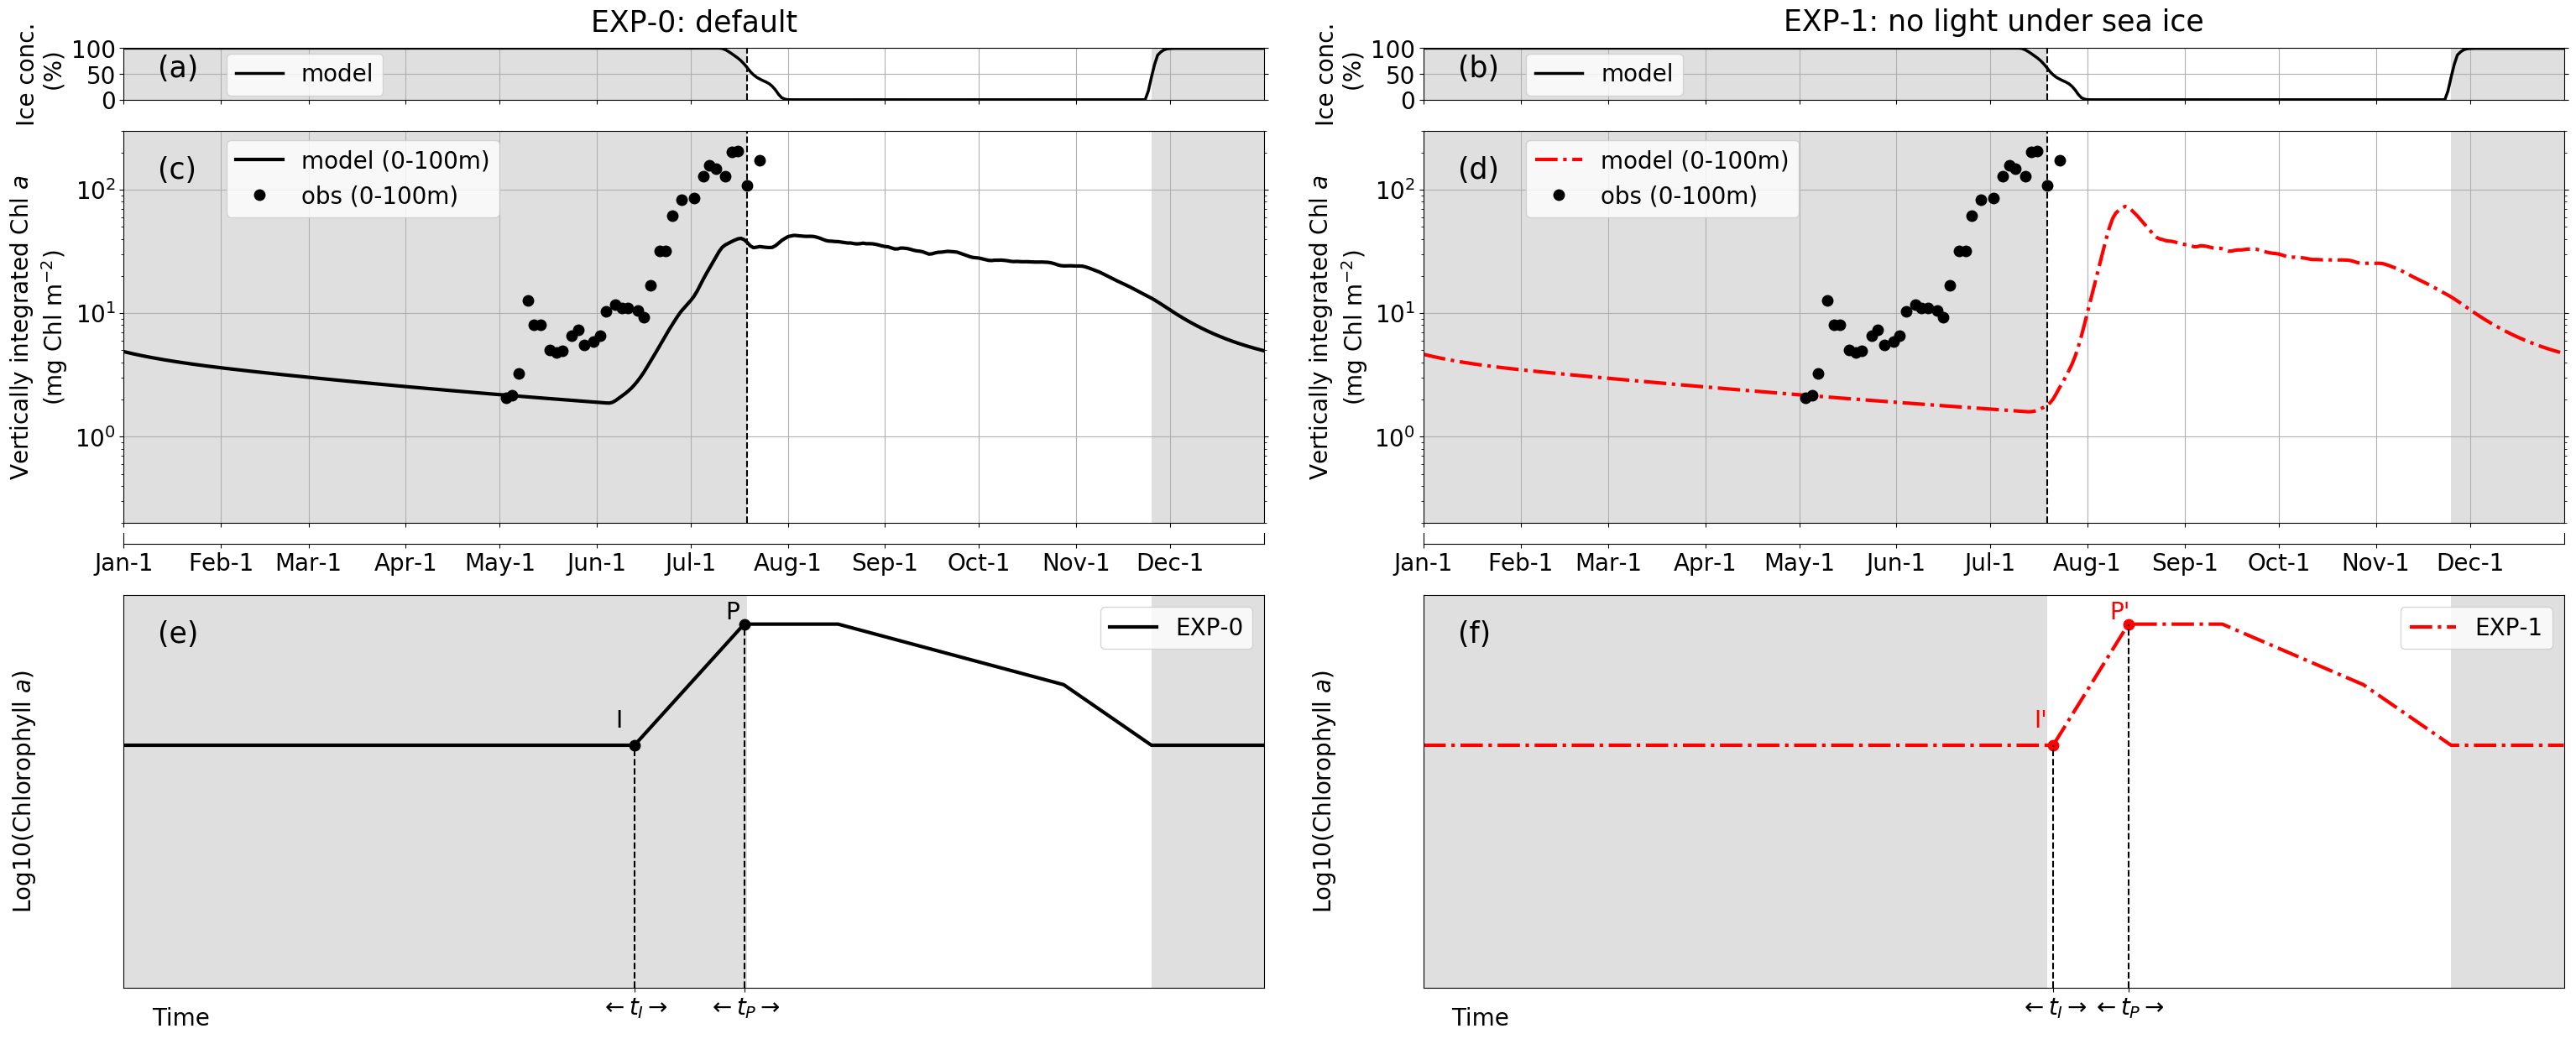

In [104]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- EXP-0: ICE CONCENTRATION
    ax=axs[0,0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(xlims)
    ymin=0
    ymax=100
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,-0.15))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.60,'(a)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    plt.text(0.5,1.5,'EXP-0: default',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-1: ICE CONCENTRATION
    ax=axs[0,1]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(xlims)
    ymin=0
    ymax=100
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,-0.15))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.60,'(b)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    plt.text(0.5,1.5,'EXP-1: no light under sea ice',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)

    # --- EXP-0: CHLOROPHYLL VINT
    ax=axs[1,0]
    h1=ax.plot(first_year,array1d_iT_modvintchl,
               '-',color='black',lw=3,label='model (0-100m)')
    h2=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs (0-100m)')
    ax.set_yscale('log')
    ymin=0.2
    ymax=300
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,0.75))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)

    # --- EXP-1: CHLOROPHYLL VINT
    ax=axs[1,1]
    h1=ax.plot(first_year,array1d_iT_exp1vintchl,
               '-.',color='red',lw=3,label='model (0-100m)')
    h2=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs (0-100m)')
    ax.set_yscale('log')
    ymin=0.2
    ymax=300
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,0.75))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-0: ADDITIONAL X-AXIS
    ax=axs[2,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- EXP-1: ADDITIONAL X-AXIS
    ax=axs[2,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- EXP-0: SCHEMATIC
    ax=axs[3,0]
    h0=ax.plot(np.array(df.exp0x),np.array(df.exp0y),
               '-',color='black',lw=3,label='EXP-0')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp0x.iloc[1],df.exp0x.iloc[2]])
    xticklabels=[r'$\leftarrow t_I \rightarrow$',
                r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='both',left=False,labelleft=False)
    ax.plot(df.exp0x.iloc[1],df.exp0y.iloc[1],
           'o',color='black')
    ax.text(df.exp0x.iloc[1]-6,df.exp0y.iloc[1]+1,'I')
    ax.plot(df.exp0x.iloc[2],df.exp0y.iloc[2],
           'o',color='black')
    ax.text(df.exp0x.iloc[2]-6,df.exp0y.iloc[2]+20,'P')
    ax.axvline(df.exp0x.iloc[1],
               ymax=( math.log10(df.exp0y.iloc[1])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axvline(df.exp0x.iloc[2],
               ymax=( math.log10(df.exp0y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-1: SCHEMATIC
    ax=axs[3,1]
    h0=ax.plot(np.array(df.exp1x),np.array(df.exp1y),
               '-.',color='red',lw=3,label='EXP-1')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp1x.iloc[1],df.exp1x.iloc[2]])
    xticklabels=[r'$\leftarrow t_I \rightarrow$',
                r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='both',left=False,labelleft=False)
    ax.plot(df.exp1x.iloc[1],df.exp1y.iloc[1],
           'o',color='red')
    ax.text(df.exp1x.iloc[1]-6,df.exp1y.iloc[1]+1,'I\'',color='red')
    ax.plot(df.exp1x.iloc[2],df.exp1y.iloc[2],
           'o',color='red')
    ax.text(df.exp1x.iloc[2]-6,df.exp1y.iloc[2]+20,'P\'',color='red')
    ax.axvline(df.exp1x.iloc[1],
               ymax=( math.log10(df.exp1y.iloc[1])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axvline(df.exp1x.iloc[2],
               ymax=( math.log10(df.exp1y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(f)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.05,0.90  ,0.43,0.05])
    axs[0,1].set_position( [0.54,0.90  ,0.43,0.05])
    axs[1,0].set_position( [0.05,0.49  ,0.43,0.38])
    axs[1,1].set_position( [0.54,0.49  ,0.43,0.38])
    axs[2,0].set_position( [0.05,0.47  ,0.43,0.01])
    axs[2,1].set_position( [0.54,0.47  ,0.43,0.01])
    axs[3,0].set_position( [0.05,0.04  ,0.43,0.38])
    axs[3,1].set_position( [0.54,0.04  ,0.43,0.38])

with plt.style.context('mplstyles/exp.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(4,2,figsize=(31.6,12.3))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/exp1.png',dpi=1000)

## Plot: EXP-2 (no minimum biomass)

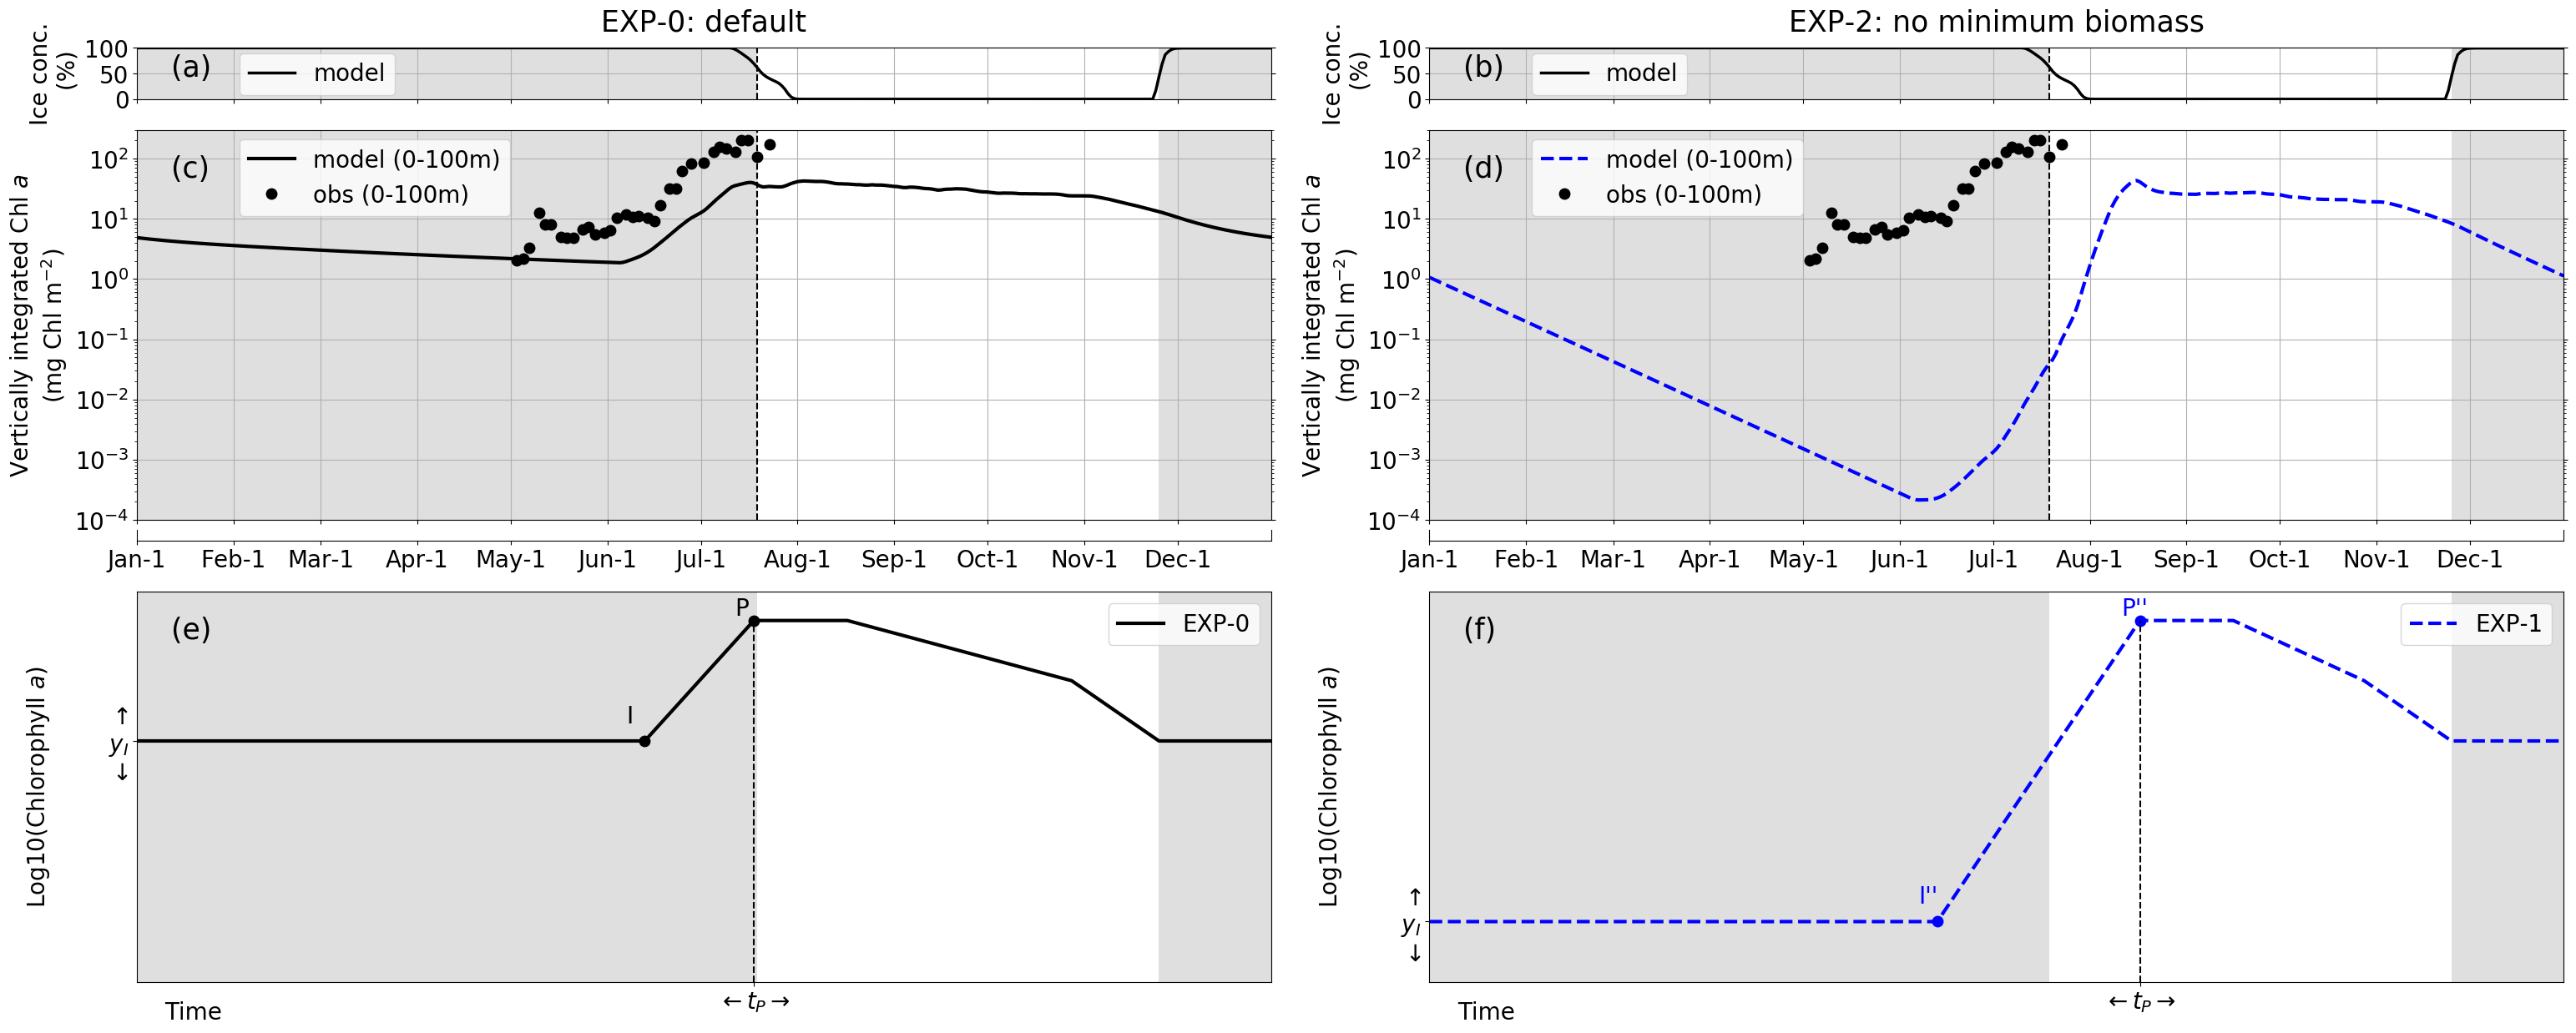

In [105]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- EXP-0: ICE CONCENTRATION
    ax=axs[0,0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(xlims)
    ymin=0
    ymax=100
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,-0.15))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.60,'(a)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    plt.text(0.5,1.5,'EXP-0: default',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-2: ICE CONCENTRATION
    ax=axs[0,1]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(xlims)
    ymin=0
    ymax=100
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,-0.15))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.60,'(b)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    plt.text(0.5,1.5,'EXP-2: no minimum biomass',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)

    # --- EXP-0: CHLOROPHYLL VINT
    ax=axs[1,0]
    h1=ax.plot(first_year,array1d_iT_modvintchl,
               '-',color='black',lw=3,label='model (0-100m)')
    h2=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs (0-100m)')
    ax.set_yscale('log')
    ymin=1E-4
    ymax=300
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,0.75))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)

    # --- EXP-2: CHLOROPHYLL VINT
    ax=axs[1,1]
    h1=ax.plot(first_year,array1d_iT_exp2vintchl,
               '--',color='blue',lw=3,label='model (0-100m)')
    h2=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs (0-100m)')
    ax.set_yscale('log')
    ymin=1E-4
    ymax=300
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,0.75))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-0: ADDITIONAL X-AXIS
    ax=axs[2,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- EXP-2: ADDITIONAL X-AXIS
    ax=axs[2,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- EXP-0: SCHEMATIC
    ax=axs[3,0]
    h0=ax.plot(np.array(df.exp0x),np.array(df.exp0y),
               '-',color='black',lw=3,label='EXP-0')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp0x.iloc[2]])
    xticklabels=[r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='minor',left=False,labelleft=False)
    yticks=([df.exp0y.iloc[0]])
    yticklabels=[r'$\uparrow$'
                 '\n'
                 r'$y_I$'
                '\n'
                r'$\downarrow$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.plot(df.exp0x.iloc[1],df.exp0y.iloc[1],
           'o',color='black')
    ax.text(df.exp0x.iloc[1]-6,df.exp0y.iloc[1]+1,'I')
    ax.plot(df.exp0x.iloc[2],df.exp0y.iloc[2],
           'o',color='black')
    ax.text(df.exp0x.iloc[2]-6,df.exp0y.iloc[2]+20,'P')
    ax.axvline(df.exp0x.iloc[2],
               ymax=( math.log10(df.exp0y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-2: SCHEMATIC
    ax=axs[3,1]
    h0=ax.plot(np.array(df.exp2x),np.array(df.exp2y),
               '--',color='blue',lw=3,label='EXP-1')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp2x.iloc[2]])
    xticklabels=[r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='minor',left=False,labelleft=False)
    yticks=([df.exp2y.iloc[0]])
    yticklabels=[r'$\uparrow$'
                 '\n'
                 r'$y_I$'
                '\n'
                r'$\downarrow$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.plot(df.exp2x.iloc[1],df.exp2y.iloc[1],
           'o',color='blue')
    ax.text(df.exp2x.iloc[1]-6,df.exp2y.iloc[1]+1E-3,'I\'\'',color='blue')
    ax.plot(df.exp2x.iloc[2],df.exp2y.iloc[2],
           'o',color='blue')
    ax.text(df.exp2x.iloc[2]-6,df.exp2y.iloc[2]+20,'P\'\'',color='blue')
    ax.axvline(df.exp2x.iloc[2],
               ymax=( math.log10(df.exp2y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(f)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.05,0.90  ,0.43,0.05])
    axs[0,1].set_position( [0.54,0.90  ,0.43,0.05])
    axs[1,0].set_position( [0.05,0.49  ,0.43,0.38])
    axs[1,1].set_position( [0.54,0.49  ,0.43,0.38])
    axs[2,0].set_position( [0.05,0.47  ,0.43,0.01])
    axs[2,1].set_position( [0.54,0.47  ,0.43,0.01])
    axs[3,0].set_position( [0.05,0.04  ,0.43,0.38])
    axs[3,1].set_position( [0.54,0.04  ,0.43,0.38])

with plt.style.context('mplstyles/exp.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(4,2,figsize=(31.6,12.3))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/exp2.png',dpi=1000)

## Plot: EXP-3 (differing wintertime nitrate)

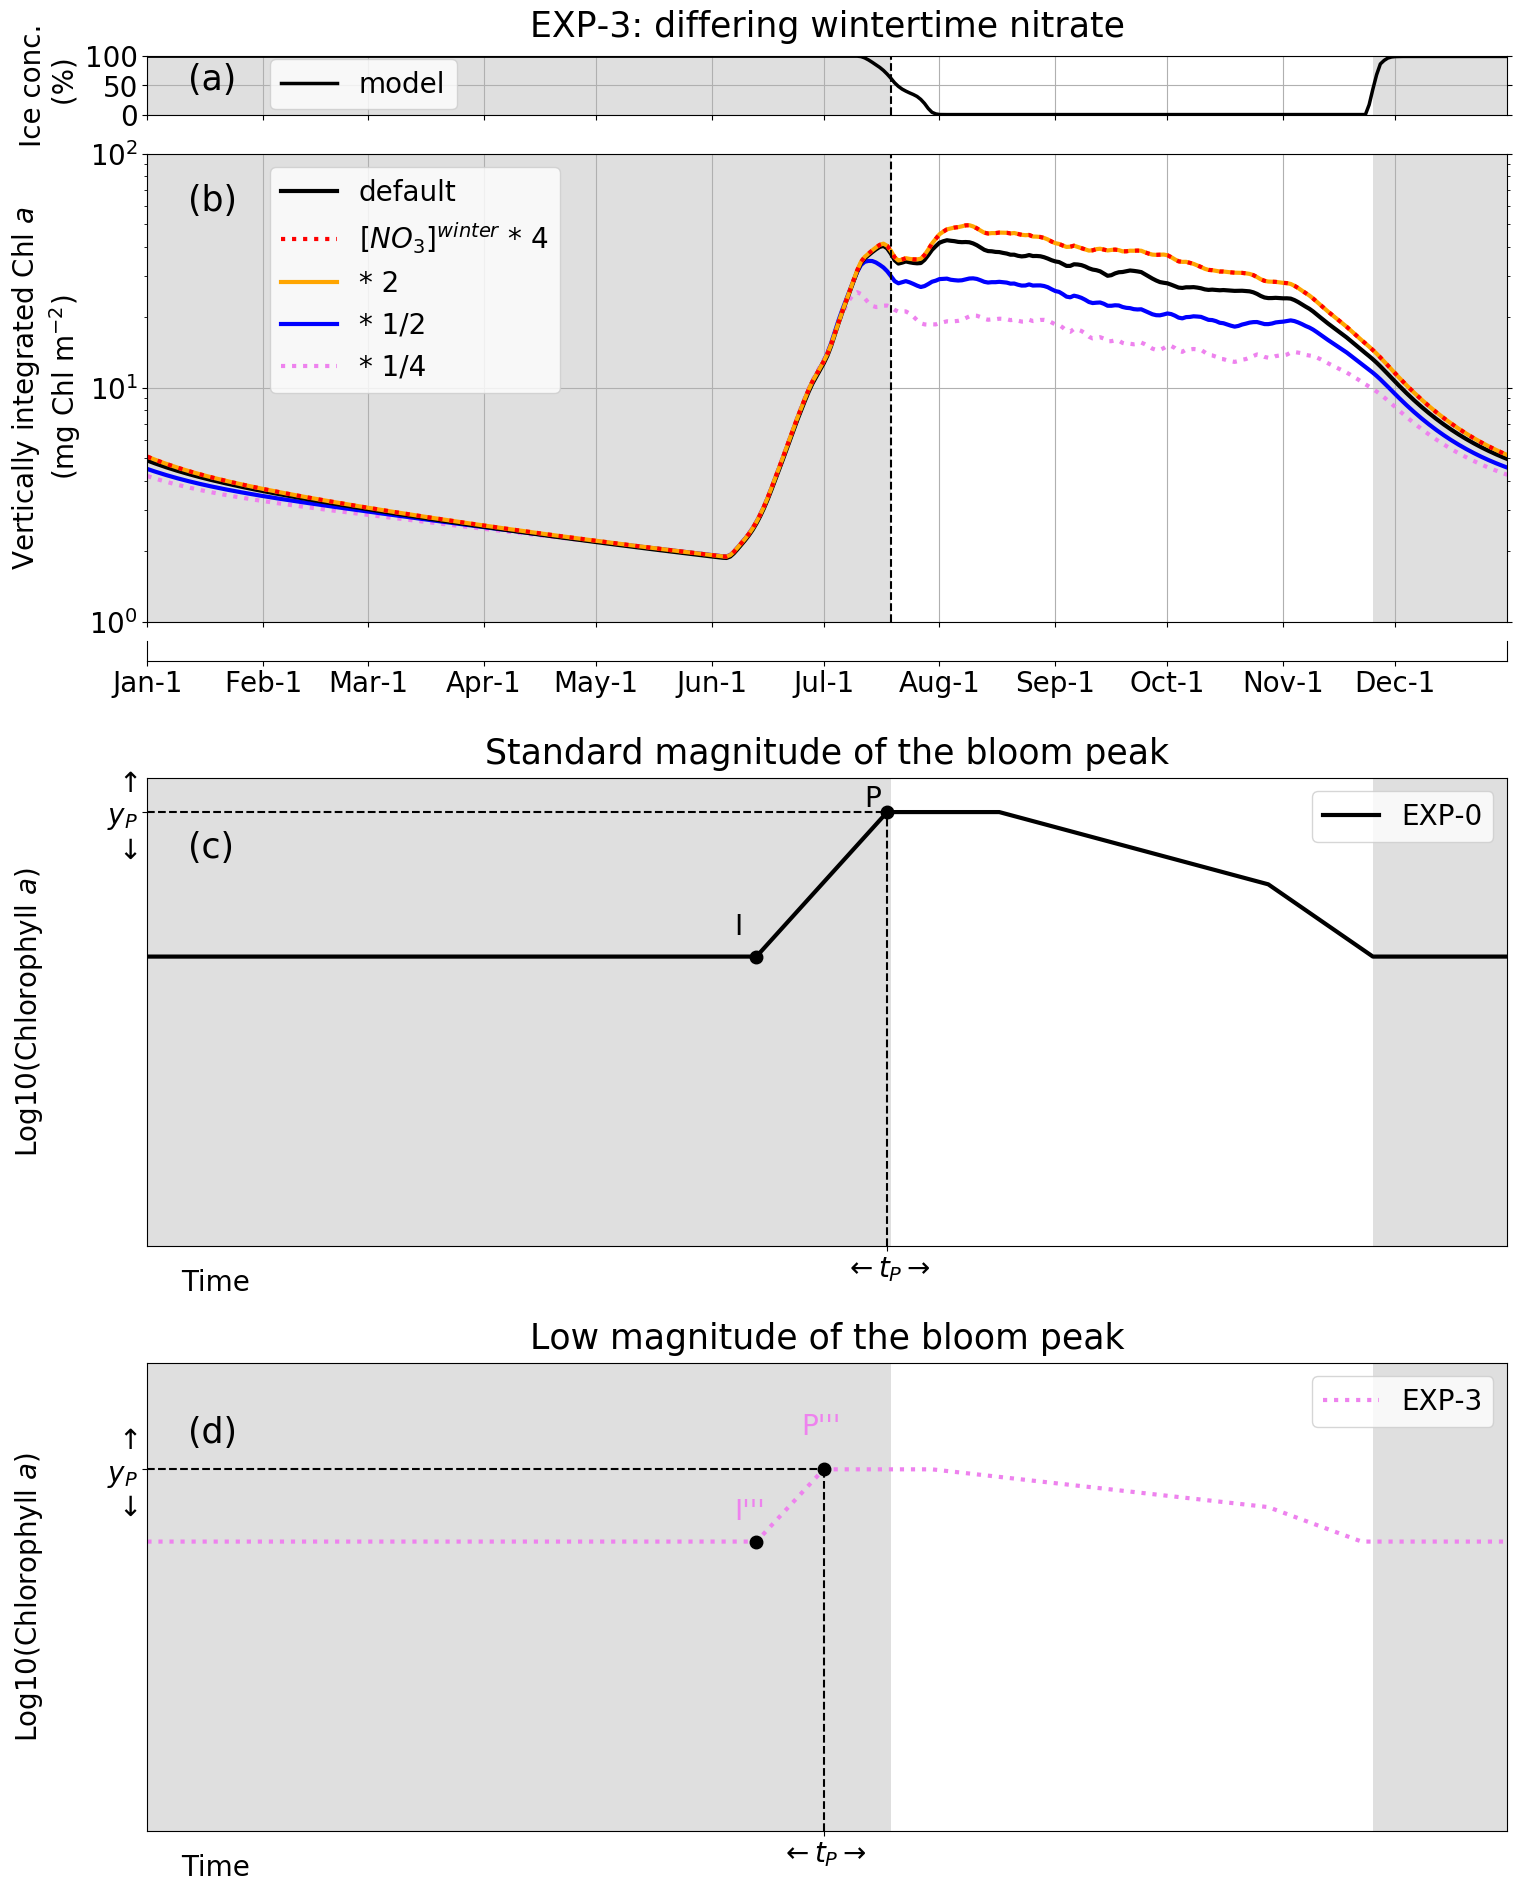

In [106]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- EXP-0: ICE CONCENTRATION
    ax=axs[0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(xlims)
    ymin=0
    ymax=100
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.08,-0.15))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.60,'(a)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.5,1.5,'EXP-3: differing wintertime nitrate',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)

    # --- EXP-0: CHLOROPHYLL VINT
    ax=axs[1]
    h0_25=ax.plot(first_year,array1d_iT_exp3times0_25vintchl,
                  ':',color='violet',lw=3,label='* 1/4')
    h0_50=ax.plot(first_year,array1d_iT_exp3times0_50vintchl,
                  '-',color='blue',lw=3,label='* 1/2')
    h1_00=ax.plot(first_year,array1d_iT_modvintchl,
                  '-',color='black',lw=3,label='default')
    h2_00=ax.plot(first_year,array1d_iT_exp3times2_00vintchl,
                  '-',color='orange',lw=3,label='* 2')
    h4_00=ax.plot(first_year,array1d_iT_exp3times4_00vintchl,
                  ':',color='red',lw=3,label='${[NO_3]}^{winter}$ * 4')
    ax.set_yscale('log')
    ymin=1E0
    ymax=1E2
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    #get handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    #specify order of items in legend
    order = [2,4,3,1,0]
    #add legend to plot
    ax.legend([handles[idx] for idx in order],
              [legend_labels [idx] for idx in order],
               loc='upper left',
               bbox_to_anchor=(0.08,1.00))
    ax.axvline(obs_breakup,color='k',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-0: ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- EXP-0: SCHEMATIC
    ax=axs[3]
    h0=ax.plot(np.array(df.exp0x),np.array(df.exp0y),
               '-',color='black',lw=3,label='EXP-0')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp0x.iloc[2]])
    xticklabels=[r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='minor',left=False,labelleft=False)
    yticks=([df.exp0y.iloc[2]])
    yticklabels=[r'$\uparrow$'
                 '\n'
                 r'$y_P$'
                '\n'
                r'$\downarrow$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.plot(df.exp0x.iloc[1],df.exp0y.iloc[1],
           'o',color='black')
    ax.text(df.exp0x.iloc[1]-6,df.exp0y.iloc[1]+1,'I')
    ax.plot(df.exp0x.iloc[2],df.exp0y.iloc[2],
           'o',color='black')
    ax.text(df.exp0x.iloc[2]-6,df.exp0y.iloc[2]+20,'P')
    ax.axvline(df.exp0x.iloc[2],
               ymax=( math.log10(df.exp0y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axhline(df.exp0y.iloc[2],
              xmax=df.exp0x.iloc[2]/xmax,
              color='black',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    ax.legend(loc='upper right')
    plt.text(0.03,0.85,'(c)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.5,1.05,'Standard magnitude of the bloom peak',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- EXP-3: SCHEMATIC
    ax=axs[4]
    h0=ax.plot(np.array(df.exp3x),np.array(df.exp3y),
               ':',color='violet',lw=3,label='EXP-3')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.05)
    ax.set_xlim(xlims)
    xticks=([df.exp3x.iloc[2]])
    xticklabels=[r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='minor',left=False,labelleft=False)
    yticks=([df.exp3y.iloc[2]])
    yticklabels=[r'$\uparrow$'
                 '\n'
                 r'$y_P$'
                '\n'
                r'$\downarrow$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.plot(df.exp3x.iloc[1],df.exp3y.iloc[1],
           'o',color='black')
    ax.text(df.exp3x.iloc[1]-6,df.exp3y.iloc[1]+1,
            'I\'\'\'',color='violet')
    ax.plot(df.exp3x.iloc[2],df.exp3y.iloc[2],
           'o',color='black')
    ax.text(df.exp3x.iloc[2]-6,df.exp3y.iloc[2]+20,
            'P\'\'\'',color='violet')
    ax.axvline(df.exp3x.iloc[2],
               ymax=( math.log10(df.exp3y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axhline(df.exp3y.iloc[2],
              xmax=df.exp3x.iloc[2]/xmax,
              color='black',linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    ax.legend(loc='upper right')
    plt.text(0.03,0.85,'(d)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.5,1.05,'Low magnitude of the bloom peak',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0].set_position([0.13,0.92, 0.85,0.03])
    axs[1].set_position([0.13,0.66, 0.85,0.24])
    axs[2].set_position([0.13,0.64, 0.85,0.01])
    axs[3].set_position([0.13,0.34, 0.85,0.24])
    axs[4].set_position([0.13,0.04, 0.85,0.24])

with plt.style.context('mplstyles/exp.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(5,1,figsize=(16,19.5))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/exp3.png',dpi=1000)

## Plot: discussion

The conceptual model and the schematic.

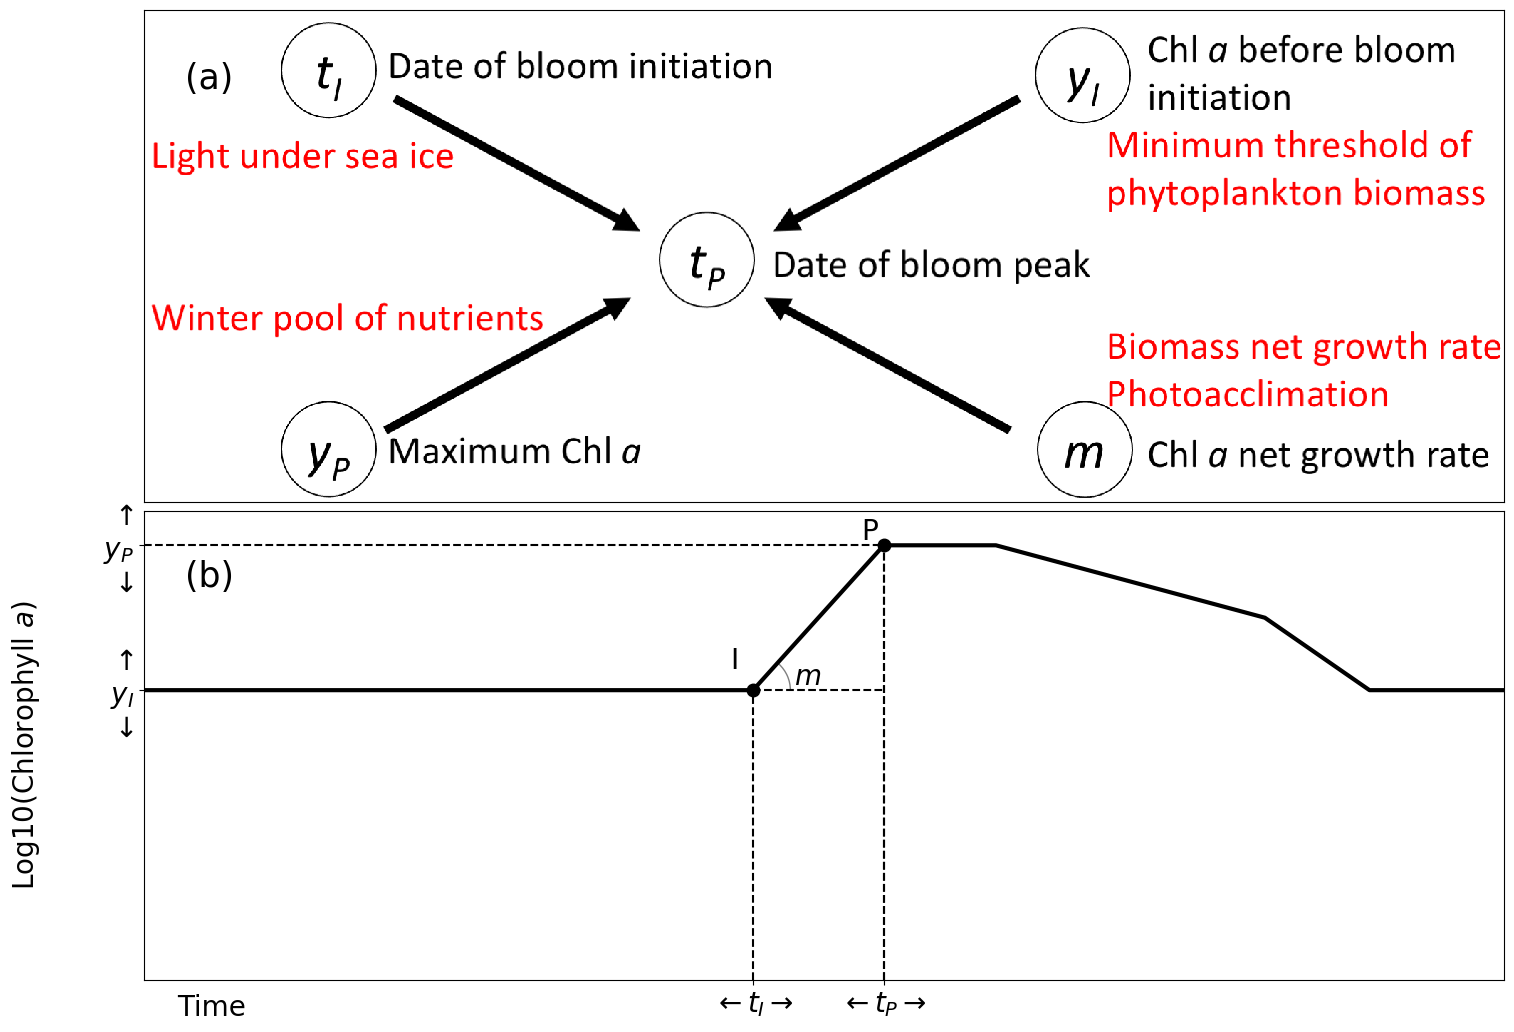

In [107]:
def make_plots(axs):
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- CONCEPTUAL MODEL
    ax=axs[0]
    im=PIL.Image.open('figures_progress/conceptual_model.png')
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.text(0.03,0.86,'(a)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- SCHEMATIC
    ax=axs[1]
    h0=ax.plot(np.array(df.exp0x),np.array(df.exp0y),
               '-',color='black',lw=3,label='EXP-0')
    ax.set_xlabel('Time')
    ax.xaxis.set_label_coords(0.05,-0.03)
    ax.set_xlim(xlims)
    xticks=([df.exp0x.iloc[1],df.exp0x.iloc[2]])
    xticklabels=[r'$\leftarrow t_I \rightarrow$',
                r'$\leftarrow t_P \rightarrow$']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yscale('log')
    ax.set_ylabel('Log10(Chlorophyll $a$)')
    ax.yaxis.set_label_coords(-0.075,0.50)
    ymin=1E-4
    ymax=300
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='y',which='minor',left=False,labelleft=False)
    yticks=([df.exp0y.iloc[0],df.exp0y.iloc[2]])
    yticklabels=[r'$\uparrow$'
                 '\n'
                 r'$y_I$'
                '\n'
                r'$\downarrow$',
                r'$\uparrow$'
                 '\n'
                 r'$y_P$'
                '\n'
                r'$\downarrow$']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.plot(df.exp0x.iloc[1],df.exp0y.iloc[1],
           'o',color='black')
    ax.text(df.exp0x.iloc[1]-6,df.exp0y.iloc[1]+1,'I')
    ax.plot(df.exp0x.iloc[2],df.exp0y.iloc[2],
           'o',color='black')
    ax.text(df.exp0x.iloc[2]-6,df.exp0y.iloc[2]+20,'P')
    ax.axvline(df.exp0x.iloc[1],
               ymax=( math.log10(df.exp0y.iloc[1])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axvline(df.exp0x.iloc[2],
               ymax=( math.log10(df.exp0y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axvline(df.exp0x.iloc[2],
               ymax=( math.log10(df.exp0y.iloc[2])-math.log10(ymin) ) \
               /    ( math.log10(ymax)            -math.log10(ymin) ),
               color='black',linestyle='--')
    ax.axhline(df.exp0y.iloc[2],
              xmax=df.exp0x.iloc[2]/xmax,
              color='black',linestyle='--')
    ax.axhline(df.exp0y.iloc[0],
              xmin=df.exp0x.iloc[1]/xmax,
              xmax=df.exp0x.iloc[2]/xmax,
              color='black',linestyle='--')
    # ref.:
    # https://stackoverflow.com/questions/68111673/matplotlib-draw-ellipse-to-annotate-on-top-of-logarithmic-scale
    # answer by tmdavison
    # Arc centre coordinates
    x,y=df.exp0x.iloc[1],df.exp0y.iloc[1]
    # use the axis scale tform to figure out how far to translate
    arc_offset=mpl.transforms.ScaledTranslation(x,y,ax.transScale)
    # construct the composite tform
    arc_tform = arc_offset + ax.transLimits + ax.transAxes
    # Create the arc centred on the origin, apply the composite tform
    width,height=20,1 # not exact, by trial and error
    theta1,theta2=0,3 # not exact, by trial and error
    arc=mpl.patches.Arc(xy=(0,0),width=width,height=height,
                        color="grey",fill=False,lw=1,
                        theta1=theta1,theta2=theta2,
                        transform=arc_tform)
    ax.add_patch(arc)
    ax.text(174,1.2,'$m$')
    plt.text(0.03,0.86,'(b)',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0].set_position([0.13,0.50, 0.85,0.50])
    axs[1].set_position([0.13,0.04, 0.85,0.46])
    
with plt.style.context('mplstyles/exp.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(2,1,figsize=(16,10.2))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_progress/discussion.png',dpi=1000)